# basic set up

In [1]:
#basic set up
%matplotlib inline
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
import os
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from IPython.display import clear_output
from matplotlib.path import Path
import pandas as pd
import pdb
from logzero import logger
from utils.common_imports import *


#netflow 
import ets_fiber_assigner.netflow as nf
import ets_fiber_assigner.io_helpers as io_helpers
from ics.cobraOps.Bench import Bench
from ics.cobraOps.TargetGroup import TargetGroup
from ics.cobraOps.CobrasCalibrationProduct import CobrasCalibrationProduct
from ics.cobraOps.BlackDotsCalibrationProduct import BlackDotsCalibrationProduct
from pfs.utils.fiberids import FiberIds

from ics.cobraCharmer.pfiDesign import PFIDesign
from ics.cobraCharmer.cobraCoach.cobraCoach import CobraCoach
from ics.cobraOps.DistanceTargetSelector import DistanceTargetSelector

from ics.cobraOps.CollisionSimulator2 import CollisionSimulator2
from ics.cobraOps.CollisionSimulator import CollisionSimulator
from ics.cobraOps.cobraConstants import NULL_TARGET_POSITION, NULL_TARGET_ID
from ics.cobraOps import plotUtils
from collections import defaultdict

# key functions

In [2]:

# read the pointing centers from the file
def read_pointings(file):
    """
    Read pre-defined pointings from a file
    """
    try:
        # first try reading as ecsv format
        t = Table.read(file, format="ascii.ecsv")
        return t["R.A."], t['Dec.']
    except:
        pass

    with open(file) as f:
        ras = []
        decs = []
        ll = f.readlines()
        for l in ll[1:]:
            if not l.startswith("#"):
                tt = l.split()
                ra, dec = (float(tt[0]), float(tt[1]))
                ras.append(ra)
                decs.append(dec)
    return np.array(ras), np.array(decs)

# TODO: try a more efficient way to contruct the target list, add alreadyObserved to the target list either in netflow Targets or in this function
def construct_tgt_list(catalog_path = "../proc_data/", \
                       fn_list = ["cos_select.ecsv", "star_select.ecsv", "sky_select.ecsv"], \
                       prefix_list = ["sci", "cal", "sky"], calibration_list = [False, True, True]):
    '''
    Construct target list
    '''
    print("construct target list:")
    for i, fn_i in enumerate(fn_list):
        fn = catalog_path + fn_i
        print(fn)
        
        # read all targets into a single list, giving them their proper types
        if(i<1):
            if(not calibration_list[i]): tgt = nf.readScientificFromFile(fn, prefix_list[i])
            if(calibration_list[i]): tgt = nf.readCalibrationFromFile(fn, prefix_list[i])
        else:
            if(not calibration_list[i]): tgt += nf.readScientificFromFile(fn, prefix_list[i])
            if(calibration_list[i]): tgt += nf.readCalibrationFromFile(fn, prefix_list[i])

    print("In total, there are %d targets." % len(tgt))

    # sample of sci targets
    sample_sci = []
    for t in tgt:
        if(t.targetclass[:3] == 'sci'): sample_sci.append([t.ID,t.ra,t.dec])  

    sample_sci = np.array(sample_sci)
    
    return tgt, sample_sci

# TODO: play with the cost value for different classes
def def_classdict():
    '''define classdict for netflow run
    
    Parameters
    ==========
    None
    
    Returns
    =======
    classdict
    '''
    # create the dictionary containing the costs and constraints for all classes
    # of targets
    classdict = {}
    classdict["sci_P1"] = {"nonObservationCost": 200,
                           "partialObservationCost": 1e6, "calib": False}
    classdict["sci_P2"] = {"nonObservationCost": 100,
                           "partialObservationCost": 1e6, "calib": False}
    
    #for ancillary targets
    classdict["anc_P1"] = {"nonObservationCost": 50,
                           "partialObservationCost": 1e6, "calib": False}
    classdict["anc_P2"] = {"nonObservationCost": 10,
                           "partialObservationCost": 1e6, "calib": False}

    #need to ask PFS project office to get the "numRequired"
    classdict["sky"] = {"numRequired": 400,
                        "nonObservationCost": 1e6, "calib": True}
    #100-200 stars - Masayuki
    classdict["cal"] = {"numRequired": 200,
                        "nonObservationCost": 1e6, "calib": True}

    return classdict



def write_output(tgt, res, tpos, telescopes, fdir_out, fn_out, t_obs=900):
    '''write the output of fiber assignment
    Parameters
    ==========
    fdir_out: string
        output folder directory
    fn_out: string
        output file name
    '''
    
    with open(fdir_out + fn_out, "w") as f:
        for i, (vis, tp, tel) in enumerate(zip(res, tpos, telescopes)):
            print("exposure {}:".format(i))
            print("  assigned Cobras: {}".format(len(vis)))
            tdict = defaultdict(int)
            f.write("# Exposure {}: duration {}s, RA: {}, Dec: {}, PA: {}\n".
                    format(i+1, t_obs, tel._ra, tel._dec, tel._posang))
            f.write("# Target    Fiber          X          Y         "
                    "RA        DEC\n")
            for tidx, cidx in vis.items():
                tdict[tgt[tidx].targetclass] += 1 #tgt[].targetclass = 'sci_Px'
                f.write("{:} {:6d} {:10.5f} {:10.5f} {:10.5f} {:10.5f}\n"
                        .format(tgt[tidx].ID, cidx+1, tp[tidx].real, tp[tidx].imag,
                                tgt[tidx].ra, tgt[tidx].dec))
            for cls, num in tdict.items():
                print("   {}: {}".format(cls, num))
                
                
def cal_completeness(tgt, res, tpos, telescopes, Plot=False, fn_fig='', Save=False, fn_fibeff=''):
    '''calculate the completeness of the targets and fiber assignment fraction
    Parameters
    ==========
    fdir_out: string
        output folder directory
    Plot: boolean
        plot the results if True 
    '''
    
    #fiber assignment fraction of each pointing
    fib_eff = [] 
    #fiber assignment fraction of pointing which observed galaxies
    fib_eff_gal = []
    fib_eff_anc = []
    #calibration targets
    fib_eff_star = []
    fib_eff_sky = []

    #objects that got allocated a fiber
    obj_allo = []
    for i, (vis, tp, tel) in enumerate(zip(res, tpos, telescopes)):
        fib_eff_t = len(vis)/2394.*100 #2394 fibers available
        fib_eff.append(fib_eff_t)

        n_fib_gal = 0
        n_fib_anc = 0
        n_fib_star = 0
        n_fib_sky = 0
        #tidx is the id in tgt list; cidx is the fiber id, starting from 0
        for tidx, cidx in vis.items():
            obj_allo.append(["Point_"+str(i+1), tel._ra, tel._dec, tel._posang, tgt[tidx].ID,
                            cidx+1, tp[tidx].real, tgt[tidx].ra, tgt[tidx].dec,
                            tgt[tidx].targetclass])

            if tgt[tidx].targetclass[:3]=='sci': n_fib_gal+=1
            if tgt[tidx].targetclass[:3]=='anc': n_fib_anc+=1
            if tgt[tidx].targetclass[:3]=='sky': n_fib_sky+=1
            if tgt[tidx].targetclass[:3]=='cal': n_fib_star+=1

        fib_eff_gal.append(n_fib_gal/2394.*100)
        fib_eff_anc.append(n_fib_anc/2394.*100)
        fib_eff_star.append(n_fib_star/2394.*100)
        fib_eff_sky.append(n_fib_sky/2394.*100)

        print("exposure {}:".format(i))
        print("assigned Cobras(%): {:.2f}%; gal--{:.2f}%, anc--{:.2f}%, sky--{:.2f}%, star--{:.2f}%". format(fib_eff[i], fib_eff_gal[i], fib_eff_anc[i], fib_eff_sky[i], fib_eff_star[i]))
    
    if(Save==True):
        np.savetxt(fn_fibeff, np.c_[fib_eff, fib_eff_gal, fib_eff_anc, fib_eff_sky, fib_eff_star])
    
    #unique tgt_class
    tgt_class = []
    for tgt_i in tgt:
        tgt_class.append(tgt_i.targetclass)
    tgt_class = np.array(tgt_class)
    uniq_tgt_class = np.unique(tgt_class)

    #completeness fraction
    tgt_class_allo = np.array([obj_allo_i[-1] for obj_allo_i in obj_allo])
    comp_out = {}
    for ii, uniq_tgt_i in enumerate(uniq_tgt_class):
        mask_i = tgt_class == uniq_tgt_i
        tot = len(tgt_class[mask_i])

        mask_ii = tgt_class_allo == uniq_tgt_i
        done = len(tgt_class_allo[mask_ii])

        comp_out[uniq_tgt_i] = done/tot
        
    print("comp_out=", comp_out)
    
    #plot
    if(Plot==True):  
        npoint_used = len(tpos)
        msk_sci_class =  [uniq_tgt_class_i[:3]=='sci' for uniq_tgt_class_i in uniq_tgt_class]
        sci_class = uniq_tgt_class[msk_sci_class]
        msk_anc_class =  [uniq_tgt_class_i[:3]=='anc' for uniq_tgt_class_i in uniq_tgt_class]
        sci_class = np.append(sci_class, uniq_tgt_class[msk_anc_class])
        print(sci_class)
        
        plt.figure(figsize=(12, 4))
        plt.subplot(121)
        for ii, sci_class_ii in enumerate(sci_class):
            plt.bar([ii+1], comp_out[sci_class_ii], width=1., fc='tomato', ec='none', alpha=0.8, zorder=10)
            plt.bar([ii+1], comp_out[sci_class_ii], width=1., ec='tomato', fc='none', lw=1)

        plt.plot([0,10], [0.8,0.8], 'k--', lw=2, zorder=11)
        plt.xticks(np.arange(len(sci_class))+1, sci_class, fontsize=15)
        plt.ylabel('completeness fraction', fontsize=15)
        plt.xlim(0, len(sci_class)+2)
        plt.ylim(0, 1.)

        plt.subplot(122)
        plt.bar(np.arange(0,len(fib_eff_gal),1), fib_eff_gal, width=0.8, fc='tomato', ec='none', alpha=0.6, zorder=10)
        plt.bar(np.arange(0,len(fib_eff_anc),1), fib_eff_anc, width=0.8, fc='purple', ec='none', alpha=0.5)
        plt.bar(np.arange(0,len(fib_eff_sky),1), fib_eff_sky, width=0.8, fc='blue', ec='none', alpha=0.5)
        plt.bar(np.arange(0,len(fib_eff_star),1), fib_eff_star, width=0.8, fc='gray', ec='none', alpha=0.5)

        plt.plot([0,npoint_used+1.], [80,80], 'k--', lw=2, zorder=11)
        plt.plot([0,npoint_used+1.], [np.mean(fib_eff_gal), np.mean(fib_eff_gal)], '--', color='tomato', lw=2, zorder=11)
        plt.plot([0,npoint_used+1.], [np.mean(fib_eff_anc), np.mean(fib_eff_anc)], '--', color='purple', lw=2, zorder=11)
        plt.plot([0,npoint_used+1.], [np.mean(fib_eff_sky), np.mean(fib_eff_sky)], '--', color='blue', lw=2, zorder=11)
        plt.plot([0,npoint_used+1.], [np.mean(fib_eff_star), np.mean(fib_eff_star)], '--', color='gray', lw=2, zorder=11)

        plt.text(npoint_used*0.8, 100, "cosmology--{:2.2f}%".format(np.mean(fib_eff_gal)), color='tomato', fontsize=12)
        plt.text(npoint_used*0.8, 92, "ancillary--{:2.2f}%".format(np.mean(fib_eff_anc)), color='purple', fontsize=12)
        plt.text(npoint_used*0.8, 84, "sky--{:2.2f}%".format(np.mean(fib_eff_sky)), color='blue', fontsize=12)
        plt.text(npoint_used*0.8, 76, "star--{:2.2f}%".format(np.mean(fib_eff_star)), color='gray', fontsize=12)
        plt.xlim(0, npoint_used+1.)
        plt.ylim(0, 110.)
        plt.xlabel('Pointing', fontsize=15)
        plt.ylabel('fiber alloc fraction', fontsize=15)

        plt.savefig(fn_fig, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        
    return comp_out

    

## execute function

In [3]:
# (DONE)TODO-0: plot the distribution of the cosmology, star, and sky
# (DONE)TODO-1: make posang and otime as input parameters
# (DONE)TODO-2: test different otime outputs of tpos and netflow
# (DONE)TODO-3: make bench, Gurobi options as input parameters
# TODO-4: test different Gurobi options, vis_cost, cobraMoveCost
# TODO-5: check blackDotPenalty, collision_distance, and minSkyTargetsPerInstrumentRegion
# TODO-6: write code to get longer exposure in the 2nd visit for some targets
# TODO-7: test which part of the code is the bottleneck
def execute(peaks, tgt, classdict, alreadyObserved, t_obs = 900., two_stage = False, collision_sim_version = 2, tele_params={"otime":"2025-08-20T11:00:00Z", "posang":0.}, bench = None, cobracoach = None, gurobiOptions = None):
    '''
    Parameters
    ==========
    two_stage (boolean): whether to do two stage assignment or not
    
    Returns
    =======
    '''
    # get a complete, idealized focal plane configuration
    if bench is None:
        Exception("bench is not defined")
    if cobracoach is None:
        Exception("cobracoach is not defined")
        
    # test_a 
    # otime = "2025-08-20T10:00:00Z"
    # test_b
    # otime = "2025-08-20T12:00:00Z"
    # test_c
    # otime = "2025-08-20T11:00:00Z"

    raTel, decTel = peaks[:, 0], peaks[:, 1]
    posang = tele_params["posang"]
    otime = tele_params["otime"]
    telescopes = []

    # number of distinct observations
    nvisit = len(raTel)

    # generate telescope pointings for every observation
    for ii in range(nvisit):
        telescopes.append(nf.Telescope(raTel[ii], decTel[ii], posang, otime))

    # get focal plane positions for all targets and all visits
    tpos = [tele.get_fp_positions(tgt) for tele in telescopes]
    
    # optional: slightly increase the cost for later observations,
    # to observe as early as possible
    # test_defualt 
    vis_cost = [0.1*i for i in range(nvisit)]
    # test_vis_cost -- no difference in the output
    # vis_cost = [0.*i for i in range(nvisit)]

    # optional: penalize assignments where the cobra has to move far out
    def cobraMoveCost(dist):
        # test_default
        return 0.01*dist 
        # test_cobraMoveCost, fiber efficency is slightly lower (75.40 versus 75.44) in one of the two pointings 
        # return 0.0001*dist
    
    # test_default
    # blackDotPenalty = None
    # optional: penalize assignments near the black dots
    # test_blackDotPenalty, note distance is in mm, same as in cobraMoveCost
    # --- fiber efficency is different, but not in a consistent way in the two pointings
    def blackDotPenalty(dist):
        #return 0.
        return 0.01*(1. - 0.5 * dist)

    # refer to gurobi website for information on these parameters, LogToConsole=1 will display the running process
    if gurobiOptions is None:
        gurobiOptions = dict(seed=0, presolve=1, method=4, degenmoves=0,
                            heuristics=0.8, mipfocus=0, mipgap=5.e-2, LogToConsole=1)
    
    forbiddenPairs = []
    for i in range(nvisit):
        forbiddenPairs.append([])

    print("solving the problem for stage=0 targets.")
    done = False
    while not done:
        # compute observation strategy for stage=0 targets (default: stage=0, preassigned=None)
        prob0 = nf.buildProblem(bench, tgt, tpos, classdict, t_obs,
                               vis_cost, cobraMoveCost=cobraMoveCost,
                               collision_distance=2., elbow_collisions=True,
                               gurobi=True, gurobiOptions=gurobiOptions,
                               alreadyObserved=alreadyObserved,
                               forbiddenPairs=forbiddenPairs, 
                               blackDotPenalty=blackDotPenalty)

        prob0.solve()
        Obj0 = prob0._prob.objVal
        
        # extract solution for stage=0
        res0 = [{} for _ in range(nvisit)]
        for k1, v1 in prob0._vardict.items():
            if k1.startswith("Tv_Cv_"):
                visited = prob0.value(v1) > 0
                if visited:
                    _, _, tidx, cidx, ivis = k1.split("_")
                    res0[int(ivis)][int(tidx)] = int(cidx)
        #    
        print("Checking for trajectory collisions")
        ncoll = 0
        for ivis, (vis, tp) in enumerate(zip(res0, tpos)):
            selectedTargets = np.full(len(bench.cobras.centers), NULL_TARGET_POSITION)
            ids = np.full(len(bench.cobras.centers), NULL_TARGET_ID)
            for tidx, cidx in vis.items():
                selectedTargets[cidx] = tp[tidx]
                ids[cidx] = ""
            for i in range(selectedTargets.size):
                if selectedTargets[i] != NULL_TARGET_POSITION:
                    dist = np.abs(selectedTargets[i]-bench.cobras.centers[i])
                    if dist > bench.cobras.L1[i] + bench.cobras.L2[i]:
                        logger.warning(
                            f"(CobraId={i}) Distance from the center exceeds L1+L2 ({dist} mm)"
                        )

            if collision_sim_version == 2:
                simulator = CollisionSimulator2(bench, cobracoach, TargetGroup(selectedTargets, ids))
            else:
                simulator = CollisionSimulator(bench, TargetGroup(selectedTargets, ids))

            simulator.run()
            if np.any(simulator.endPointCollisions):
                print("ERROR: detected end point collision, which should be impossible")

            coll_tidx = []
            for tidx, cidx in vis.items():
                if simulator.collisions[cidx]:
                    coll_tidx.append(tidx)
            ncoll += len(coll_tidx)
            for i1 in range(0,len(coll_tidx)):
                found = False
                for i2 in range(i1 + 1, len(coll_tidx)):
                    if np.abs(tp[coll_tidx[i1]] - tp[coll_tidx[i2]])<10:
                        forbiddenPairs[ivis].append((coll_tidx[i1],coll_tidx[i2]))
                        found = True
                if not found:  # not a collision between two active Cobras
                    forbiddenPairs[ivis].append((coll_tidx[i1],))

        print("trajectory collisions found:", ncoll)
        done = ncoll == 0
        
    print("Done: solving the problem for stage=0 targets.")
    
    if((two_stage==False)):
        return res0, tpos, telescopes
    
    ####################################
    print("solving the problem for stage=1 targets.")
    #reset forbiddenPairs here again
    forbiddenPairs = []
    for i in range(nvisit):
        forbiddenPairs.append([])
    
    # get preassigned_list
    preassigned_list = [{} for _ in range(nvisit)] #list (dict(TargetID: Cobra index))
    for i, vis in enumerate(res0):
        for tidx, cidx in vis.items():
            preassigned_list[i][tgt[tidx].ID] = cidx
          
    done = False
    while not done:
        #note adding stage=1 in nf.buildProblem() does not make too much difference
        prob1 = nf.buildProblem(bench, tgt, tpos, classdict, t_obs,
                                vis_cost, cobraMoveCost=cobraMoveCost,
                                collision_distance=2., elbow_collisions=True,
                                gurobi=True, gurobiOptions=gurobiOptions,
                                alreadyObserved=alreadyObserved,
                                forbiddenPairs=forbiddenPairs,
                                blackDotPenalty=blackDotPenalty,
                                stage=1, preassigned=preassigned_list)
        
        
        prob1.solve()
        Obj1 = prob1._prob.objVal
            
        # extract solution for stage=1
        res = [{} for _ in range(nvisit)]
        for k1, v1 in prob1._vardict.items():
            if k1.startswith("Tv_Cv_"):
                visited = prob1.value(v1) > 0
                if visited:
                    _, _, tidx, cidx, ivis = k1.split("_")
                    res[int(ivis)][int(tidx)] = int(cidx)
        

        print("Checking for trajectory collisions")
        ncoll = 0
        for ivis, (vis, tp) in enumerate(zip(res, tpos)):
            selectedTargets = np.full(len(bench.cobras.centers), NULL_TARGET_POSITION)
            ids = np.full(len(bench.cobras.centers), NULL_TARGET_ID)
            for tidx, cidx in vis.items():
                selectedTargets[cidx] = tp[tidx]
                ids[cidx] = ""
            for i in range(selectedTargets.size):
                if selectedTargets[i] != NULL_TARGET_POSITION:
                    dist = np.abs(selectedTargets[i]-bench.cobras.centers[i])
                    if dist > bench.cobras.L1[i] + bench.cobras.L2[i]:
                        logger.warning(
                            f"(CobraId={i}) Distance from the center exceeds L1+L2 ({dist} mm)"
                        )

            if collision_sim_version == 2:
                selector = DistanceTargetSelector(bench, TargetGroup(selectedTargets, ids))
                selector.run()
                selectedTargets = selector.getSelectedTargets()
                simulator = CollisionSimulator2(bench, cobracoach, selectedTargets)
            else:
                simulator = CollisionSimulator(bench, TargetGroup(selectedTargets, ids))
            simulator.run()
            if np.any(simulator.endPointCollisions):
                print("ERROR: detected end point collision, which should be impossible")
            coll_tidx = []
            for tidx, cidx in vis.items():
                if simulator.collisions[cidx]:
                    coll_tidx.append(tidx)
            ncoll += len(coll_tidx)
            for i1 in range(0,len(coll_tidx)):
                found = False
                for i2 in range(i1+1,len(coll_tidx)):
                    if np.abs(tp[coll_tidx[i1]]-tp[coll_tidx[i2]])<10:
                        forbiddenPairs[ivis].append((coll_tidx[i1],coll_tidx[i2]))
                        found = True
                if not found:  # not a collision between two active Cobras
                    forbiddenPairs[ivis].append((coll_tidx[i1],))

        print("trajectory collisions found:", ncoll)
        done = ncoll == 0
        
    print("Done: solving the problem for stage=1 targets.")
    ####################################
    
    #clear_output()
    
    if((two_stage == True)):
        print("objVal0 = %f, objVal1=%f" % (Obj0, Obj1))   
    else:
        print("objVal0 = %f" % (Obj0)) 
    
    return res, tpos, telescopes

## write pfsDesign file

In [4]:
# TODO: this function is not working and can be removed later
def write_pfsDesign(fdir_out, fn_out, res, tpos, telescopes, tgt, classdict):
    '''write the output of fiber assignment
    Parameters
    ==========
    fdir_out: string
        output folder directory
    fn_out: string
        output file name
        
    '''
    for i, (vis, tp, tel) in enumerate(zip(res, tpos, telescopes)):
        io_helpers.writePfsDesign(pfsDesignDirectory=fdir_out, vis=vis, tp=tp, tel=tel, tgt=tgt, classdict=classdict)

## plot_filter_fov function

In [5]:

# TODO: same function as in pointings.ipynb
def plot_filter_fov(raP, decP, raSci, decSci, PA=0, n_sci_fov_least=3000, filter_fov=True):
    '''plot one PFS FoV (hexagon) centered at the pointing center
    
    NOTE
    ==========
    flag_fov_reserved is obtained by using a threshold of targets in the FoV

    Parameters
    ==========
    raP, decP, PA : float
        ra, dec, PA of the pointing center

    raSci, decSci: numpy array, float
        ra, dec of the scientific targets
        only used to check the number of scientific targets in the FoV
    
    n_sci_fov_least: int
        the least number of scientific targets in the FoV

    filter_fov: Boolean
        if True, plot/select the FoV only when there are enough scientific targets in the FoV

        
    Returns
    =======
    plot a hexagon at the pointing center with diameter=1.38 deg
    
    flag_fov_reserved: Boolean, used to remove the pointing w/o enough scientific targets 
    '''
    
    center = SkyCoord(raP*u.deg, decP*u.deg)
    # PA=0 along y-axis, PA=90 along x-axis, PA=180 along -y-axis...
    hexagon = center.directional_offset_by([0+PA, 60+PA, 120+PA, 180+PA, 240+PA, 300+PA, 360+PA]*u.deg, 1.38/2.*u.deg)
    ra_h = hexagon.ra.deg
    dec_h = hexagon.dec.deg

    ra_h_in = np.where(np.fabs(ra_h-center.ra.deg)>180)
    if len(ra_h_in[0])>0:
        if ra_h[ra_h_in[0][0]]>180:ra_h[ra_h_in[0]]-=360
        elif ra_h[ra_h_in[0][0]]<180:ra_h[ra_h_in[0]]+=360
        #pdb.set_trace()

    # scientific targets
    point = np.vstack((raSci, decSci)).T
    
    # TODO: revise the polygon.contains_points for the ra near 0 and 360 cases
    if filter_fov:
        polygon = Path([(ra_h[t],dec_h[t]) for t in range(len(ra_h))])
        index_ = np.where(polygon.contains_points(point)==True)[0]

        if(len(index_)<n_sci_fov_least):
            flag_fov_reserved = False
        else:
            flag_fov_reserved = True
            plt.plot(ra_h, dec_h, color='r', lw=0.5, ls='-', alpha=1., zorder=5)
    else:
        flag_fov_reserved = True
        plt.plot(ra_h, dec_h, color='r', lw=0.5, ls='-', alpha=1., zorder=5)
    
    return flag_fov_reserved

## check_output function

In [6]:
# TODO: make this function useful for one/multiple pointings, plot the cosmology, star, sky and ancillary targets using different colors
def plot_tgt_done(outfn_list, figname, figsize=(8, 8), plot_diffcolor=True):
    '''
    plot the targets that have been assigned to the fibers
    '''
    for i, fn_i in enumerate(outfn_list):
        tgt_id_done, tgt_ra_done, tgt_dec_done = np.loadtxt(fn_i, usecols=(0, 4, 5), unpack=True, dtype='str')
        tgt_ra_done, tgt_dec_done = tgt_ra_done.astype('float'), tgt_dec_done.astype('float')

        mask_cos = [tgt_id_done[i][1:4] == 'Cos' for i in range(len(tgt_id_done))]
        mask_star = [tgt_id_done[i][1:4] == 'Sta' for i in range(len(tgt_id_done))]
        mask_sky = [tgt_id_done[i][1:4] == 'Sky' for i in range(len(tgt_id_done))]
        mask_anc = [tgt_id_done[i][1:4] == 'Anc' for i in range(len(tgt_id_done))]

        if(plot_diffcolor):
            if(i==0): 
                plt.figure(figsize = figsize)
                plt.plot(tgt_ra_done[mask_cos], tgt_dec_done[mask_cos], 'k.', ms=0.5, alpha=0.5, label='cosmology')
                plt.plot(tgt_ra_done[mask_star], tgt_dec_done[mask_star], 'r*', ms=1.5, alpha=1., label='star')
                plt.plot(tgt_ra_done[mask_sky], tgt_dec_done[mask_sky], 'b^', ms=1.5, alpha=1., label='sky')
                plt.plot(tgt_ra_done[mask_anc], tgt_dec_done[mask_anc], 'gs', ms=1.5, alpha=1., label='ancillary')
            else:
                plt.plot(tgt_ra_done[mask_cos], tgt_dec_done[mask_cos], 'k.', ms=0.5, alpha=0.5)
                plt.plot(tgt_ra_done[mask_star], tgt_dec_done[mask_star], 'r*', ms=1.5, alpha=1.)
                plt.plot(tgt_ra_done[mask_sky], tgt_dec_done[mask_sky], 'b^', ms=1.5, alpha=1.)
                plt.plot(tgt_ra_done[mask_anc], tgt_dec_done[mask_anc], 'gs', ms=1.5, alpha=1.)
        else:
            if(i==0): 
                plt.figure(figsize = figsize)
                plt.plot(tgt_ra_done, tgt_dec_done, 'k.', ms=0.5, alpha=0.5, label='targets done')
            else:
                plt.plot(tgt_ra_done, tgt_dec_done, 'k.', ms=0.5, alpha=0.5)

    plt.legend(loc='upper right', fontsize=15, frameon=True)
    plt.xlabel('RA', fontsize=15)
    plt.ylabel('DEC', fontsize=15)
    plt.savefig(figname, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

## set bench

In [7]:
# TODO: check with project office if the following function is correct
# double check calibration_ga using https://github.com/Subaru-PFS/ets_pointing/blob/afa0ff9577f3077ae1fd758bb3ddd426e8d24f4d/src/pfs_design_tool/pointing_utils/nfutils.py#L47
import pathlib
def create_bench(layout="full"):
    '''
    set bench using different methods

    using CollisionSimulator2 for trajectory collision check when layout is not "full"
    '''
    cobra_coach_dir = "./cobra_coach_temp/"
    fiberids_path = "./pfs_utils-w.2024.45/data/fiberids/"
    #pfs_black_dots_path = "./pfs_instdata-1.8.14/data/pfi/dot/black_dots_mm.csv"
    #pfs_pfi_module_path = pathlib.Path("./pfs_instdata-1.8.14/data/pfi/modules/ALL/ALL_final.xml")
    pfs_black_dots_path = "./pfs_instdata-1.8.2/data/pfi/dot/black_dots_mm.csv"
    pfs_pfi_module_path = pathlib.Path("./pfs_instdata-1.8.2/data/pfi/modules/ALL/ALL_final.xml")


    spectrograph_modules = [1, 2, 3, 4]

    # Create the cobra coach temp directory if it does not exist
    if not os.path.isdir(cobra_coach_dir):
        os.makedirs(cobra_coach_dir, exist_ok=True)
    print(f"Created cobra coach temp directory: {cobra_coach_dir}")

    pfs_instdata_path = "./pfs_instdata-1.8.14/"
    os.environ["PFS_INSTDATA_DIR"] = pfs_instdata_path

    if layout == "full":
        '''
        use CollisionSimulator (not CollisionSimulator2) when layout is "full"
        '''
        bench = Bench(layout="full")
        cobracoach = None
    elif layout == "calibration_ga":
        '''
        use the same code as in GA github repository, i.e.,
        _create_configured_bench() https://github.com/Subaru-PFS-GA/ga_targeting/blob/master/python/pfs/ga/targeting/instrument/subarupfi.py
        '''
        cobracoach = CobraCoach("fpga", loadModel=False, trajectoryMode=True, rootDir=cobra_coach_dir)
        cobracoach.loadModel(version="ALL", moduleVersion=None)
        calibrationProduct = cobracoach.calibModel

        # Set some dummy center positions and phi angles for those cobras that have
        # zero centers
        zeroCenters = calibrationProduct.centers == 0
        calibrationProduct.centers[zeroCenters] = np.arange(np.sum(zeroCenters)) * 300j
        calibrationProduct.phiIn[zeroCenters] = -np.pi
        calibrationProduct.phiOut[zeroCenters] = 0
        print("Cobras with zero centers: %i" % np.sum(zeroCenters))

        # Use the median value link lengths in those cobras with zero link lengths
        zeroLinkLengths = (calibrationProduct.L1 == 0) | (calibrationProduct.L2 == 0)
        calibrationProduct.L1[zeroLinkLengths] = np.median(calibrationProduct.L1[~zeroLinkLengths])
        calibrationProduct.L2[zeroLinkLengths] = np.median(calibrationProduct.L2[~zeroLinkLengths])
        print("Cobras with zero link lengths: %i" % np.sum(zeroLinkLengths))

        # Use the median value link lengths in those cobras with too long link lengths (extra part compared to ga setting)
        tooLongLinkLengths = np.logical_or(
            calibrationProduct.L1 > 100, calibrationProduct.L2 > 100
        )
        calibrationProduct.L1[tooLongLinkLengths] = np.median(
            calibrationProduct.L1[~tooLongLinkLengths]
        )
        calibrationProduct.L2[tooLongLinkLengths] = np.median(
            calibrationProduct.L2[~tooLongLinkLengths]
        )
        print("Cobras with too long link lengths: %i" % np.sum(tooLongLinkLengths))

        # Limit spectral modules
        gfm = FiberIds(path=fiberids_path) 
        cobra_ids_use = np.array([], dtype=np.uint16)
        for sm in spectrograph_modules:
            cobra_ids_use = np.append(cobra_ids_use, gfm.cobrasForSpectrograph(sm))

        # Set Bad Cobra status for unused spectral modules
        for cobra_id in range(calibrationProduct.nCobras):
            if cobra_id not in cobra_ids_use:
                calibrationProduct.status[cobra_id] = ~PFIDesign.COBRA_OK_MASK
            
        bench = Bench(
                layout="calibration",                       
                calibrationProduct=calibrationProduct,
                blackDotsCalibrationProduct=BlackDotsCalibrationProduct(pfs_black_dots_path)
                )
        
        print("Number of cobras:", bench.cobras.nCobras)
        
    elif layout == "calibration_cobrascalibrationproduct":
        '''
        use CobrasCalibrationProduct(
            "./pfs_instdata-1.8.14/data/pfi/modules/ALL/ALL.xml") 
        '''
        cobracoach = CobraCoach("fpga", loadModel=False, trajectoryMode=True, rootDir=cobra_coach_dir)
        cobracoach.loadModel(version="ALL", moduleVersion=None)

        bench = Bench(
            layout="calibration", 
            calibrationProduct=CobrasCalibrationProduct(
            "./pfs_instdata-1.8.14/data/pfi/modules/ALL/ALL.xml"),
            blackDotsCalibrationProduct=BlackDotsCalibrationProduct(
            "./pfs_instdata-1.8.14/data/pfi/dot/black_dots_mm.csv")
        )

    elif layout == "calibration_pfi_module":
        '''
        use ALL_final.xml 
        '''
        cobracoach = CobraCoach("fpga", loadModel=False, trajectoryMode=True, rootDir=cobra_coach_dir)
        cobracoach.loadModel(file=pfs_pfi_module_path)
        calibrationProduct = cobracoach.calibModel

        '''
        # Limit spectral modules
        gfm = create_grand_fiber_map(fiberids_path)
        cobra_ids_use = np.array([], dtype=np.uint16)
        for sm in spectrograph_modules:
            cobra_ids_use = np.append(cobra_ids_use, gfm.cobrasForSpectrograph(sm))

        # Set Bad Cobra status for unused spectral modules
        for cobra_id in range(calibrationProduct.nCobras):
            if cobra_id not in cobra_ids_use:
                calibrationProduct.status[cobra_id] = ~PFIDesign.COBRA_OK_MASK
        '''
        bench = Bench(
                layout="calibration",                       
                calibrationProduct=calibrationProduct,
                blackDotsCalibrationProduct=BlackDotsCalibrationProduct(pfs_black_dots_path)
                )
        

    return bench, cobracoach

# main function

## construct tgt list and read pointing centers

construct target list:
../data_proc/test/cosmology_region3_3h_targets.ecsv
../data_proc/test/star_region3_3h_targets.ecsv
../data_proc/test/sky_region3_3h_targets.ecsv
In total, there are 1656943 targets.


2025-01-15 09:55:14.511Z matplotlib.font_manager 10 font_manager.py:1378 findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=20.0.
2025-01-15 09:55:14.512Z matplotlib.font_manager 10 font_manager.py:1390 findfont: score(FontEntry(fname='/Users/jing/anaconda3/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2025-01-15 09:55:14.513Z matplotlib.font_manager 10 font_manager.py:1390 findfont: score(FontEntry(fname='/Users/jing/anaconda3/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBolIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2025-01-15 09:55:14.514Z matplotlib.font_manager 10 font_manager.py:1390 findfont: score(FontEntry(fname='/Users/jing/anaconda3/lib/python3.10/site-packages/matplotlib

Time passed - construct target list: 34.92 secs
There are 12 pointings.
  Your sample (gray), with the pointings (red):


2025-01-15 09:55:14.698Z matplotlib.font_manager 10 font_manager.py:1390 findfont: score(FontEntry(fname='/System/Library/Fonts/ヒラギノ角ゴシック W9.ttc', name='Hiragino Sans', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
2025-01-15 09:55:14.698Z matplotlib.font_manager 10 font_manager.py:1390 findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansOldTurkic-Regular.ttf', name='Noto Sans Old Turkic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-01-15 09:55:14.699Z matplotlib.font_manager 10 font_manager.py:1390 findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansPauCinHau-Regular.ttf', name='Noto Sans Pau Cin Hau', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-01-15 09:55:14.700Z matplotlib.font_manager 10 font_manager.py:1390 findfont: score(FontEntry(fname='/System/Library/Fonts/STHeiti Medium.ttc', name

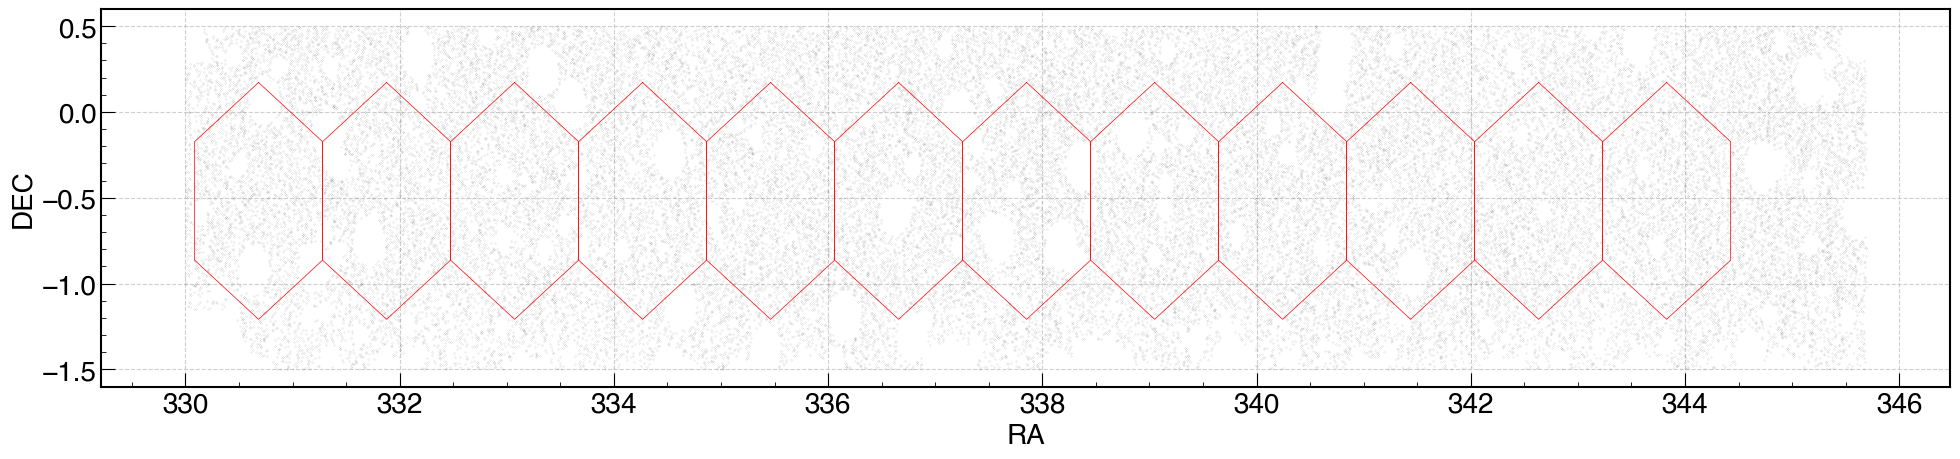

Time passed - read pointings and plot for a small region: 2.04 secs


In [8]:
# TODO: revise the two-stage code structure
two_stage = True
outdir = "../output/test/"
    
t0 = time.time()
########################
#cosmology + sky + star targets
fn_list = ["cosmology_region3_3h_targets.ecsv", "star_region3_3h_targets.ecsv", "sky_region3_3h_targets.ecsv"]
prefix_list = ["sci", "cal", "sky"]
calibration_list = [False, True, True]
    
tgt_s0, sample_sci = construct_tgt_list(catalog_path = "../data_proc/test/", fn_list=fn_list, prefix_list=prefix_list, calibration_list=calibration_list)
    
'''
# TODO: prepare ancillary science targets (smaller size sample)
#anxillary science targets
fn_list = ["anc_select.ecsv", ]
prefix_list = ["anc", ]
calibration_list = [False, ]
    
tgt_s1, sample_sci_s1 = construct_tgt_list(catalog_path = "../data_proc/", fn_list=fn_list, prefix_list=prefix_list, calibration_list=calibration_list)
'''

#total targets
#tgt = tgt_s0 + tgt_s1
tgt = tgt_s0
    
n_sci = sample_sci.shape[0]
ra_sci = sample_sci[:, 1].astype('float')
dec_sci = sample_sci[:, 2].astype('float')

t1 = time.time()
print("Time passed - construct target list: %.2f secs" % (t1-t0))

#set the range for getting pointing centers
ra_min, ra_max, dec_min, dec_max = 330, 345, -1.5, 0.5

# read the pointing centers from the file
ra_peaks, dec_peaks = read_pointings("../output/cosmology_region3_pointings.txt")

# select peaks within the range
mask_peaks = (ra_peaks>ra_min) & (ra_peaks<ra_max) & (dec_peaks>dec_min) & (dec_peaks<dec_max)
peaks = np.array([ra_peaks[mask_peaks], dec_peaks[mask_peaks]]).T
npoint = peaks.shape[0]
print("There are %d pointings." % npoint)
    
# plot the pointing and samples
plt.figure(figsize=(20, 5))
print("  Your sample (gray), with the pointings (red):")
fov_diag = 1.38/2. # deg, here it's radius
mask_sci = (ra_sci>ra_min-fov_diag) & (ra_sci<ra_max+fov_diag) & (dec_sci>dec_min-fov_diag) & (dec_sci<dec_max+fov_diag)
plt.plot(ra_sci[mask_sci][::10], dec_sci[mask_sci][::10], 'k.', ms=0.2, alpha=0.5)

for raP, decP in zip(peaks[:, 0], peaks[:, 1]):
    flag_fov_reserved = plot_filter_fov(raP, decP, ra_sci[mask_sci], dec_sci[mask_sci], PA=0, n_sci_fov_least=4000, filter_fov=True)

plt.xlabel('RA', fontsize=20)
plt.ylabel('DEC', fontsize=20)
plt.savefig(outdir + 'cosmology_region3_test_fov_plot.png')
plt.show()
plt.close()
    
t2 = time.time()
print("Time passed - read pointings and plot for a small region: %.2f secs" % (t2-t1))

## other setting

In [9]:
tele_params = {"otime":"2025-08-20T11:00:00Z", "posang":0.}
gurobiOptions = dict(seed=0, presolve=1, method=4, degenmoves=0, heuristics=0.8, mipfocus=0, mipgap=5.e-2, LogToConsole=1)


########################
classdict = def_classdict()

########################
# one visit -- can be 1st or 2nd visit
# TODO: set the alreadyObserved dictionary using the alreadyObserved column in the target list
alreadyObserved={}
for t in tgt:
    alreadyObserved[t.ID] = 0

# set the stage of cosmology targets to be 1 (i.e. stage=0 for calibration targets to get a uniform distribution for calibration targets)
# TODO: use CobraGroup to get a uniform distribution for calibration targets
for t in tgt:
    if t.targetclass[:3] == 'sci': t.stage = 1

## run_main function

In [10]:
#if __name__ == "__main__":
# main run
def run_main(peaks, tgt, classdict, alreadyObserved, two_stage=True, collision_sim_version=2, bench=None, cobracoach=None, gurobiOptions=None, tele_params=None):
    '''
    test for one pointing
    '''
    outfn_list = []
    for peak in peaks[:1]:
        # select the tgt list for the pointing
        tgt_ra = [tgt[i].ra for i in range(len(tgt))]
        tgt_dec = [tgt[i].dec for i in range(len(tgt))]
        # TO-DO: deal with the case when the ra is near 0 and 360
        mask_tgt = (tgt_ra>peak[0]-fov_diag) & (tgt_ra<peak[0]+fov_diag) & (tgt_dec>peak[1]-fov_diag) & (tgt_dec<peak[1]+fov_diag)
        tgt_peak = np.array(tgt)[mask_tgt].tolist()

        # (Done) TODO: update the alreadyObserved dictionary
        # TODO: rewrite the write_output and cal_completeness part

        # excute the fiber assignment
        res, tpos, telescopes = execute(np.array([peak]), tgt_peak, classdict, alreadyObserved, two_stage=two_stage, collision_sim_version=collision_sim_version, bench=bench, cobracoach=cobracoach, gurobiOptions=gurobiOptions, tele_params=tele_params)

        outfn = 'cosmology_region3_3h_output_v1_ra%.2f_dec%.2f.txt'%(peak[0], peak[1])
        write_output(tgt_peak, res, tpos, telescopes, outdir, outfn)

        outfn_list.append(outdir + outfn)
        
        # calculate the completeness and fiber assignment fraction
        comp_out_tmp1 = cal_completeness(tgt_peak, res, tpos, telescopes, Plot=True, fn_fig=outdir+'cosmology_region3_3h_v1_ra%.2f_dec%.2f.jpg'%(peak[0], peak[1]), Save=True, fn_fibeff=outdir+'cosmology_region3_3h_fibeff_v1.txt')
        
        # output the completeness and fiber assignment fraction
        data_dict = {key: [value] for key, value in comp_out_tmp1.items()}
        df = pd.DataFrame(data_dict)
        df.to_csv(outdir + 'cosmology_region3_3h_v1_ra%.2f_dec%.2f.csv'%(peak[0], peak[1]), index=False)
        print("comp_out_tmp1 = ", comp_out_tmp1)

        # update alreadyObserved
        # TODO: revise the code for a more general case
        tgt_id_done = np.loadtxt(outdir + outfn, usecols=(0, ), unpack=True, dtype='str')
        for t in tgt_id_done:
            if(t[:3]=='sci'): alreadyObserved[str(t)] = 1

    print("%f secs passed after the visits done." % (time.time()-t0))

    plot_tgt_done(outfn_list, outdir+'tgt_done_region3_3h_v1.jpg', figsize=(6, 5))
    plot_tgt_done(outfn_list, outdir+'tgt_done_region3_3h_v1_gray.jpg', figsize=(6, 5), plot_diffcolor=False)

# test bench setting

+ pfs_instdata tagged 1.8.14 ? This contains the latest xml file. 
https://github.com/Subaru-PFS/pfs_instdata/releases/tag/1.8.14
+ for pfs_utils, could we use the latest tagged version, w.2024.45
https://github.com/Subaru-PFS/pfs_utils/releases/tag/w.2024.45

## full + CollisionSimulator

In [11]:
'''
Comment: successfully tested for one pointing within 43 seconds

bench, cobracoach = create_bench(layout="full")
collision_sim_version = 0
run_main(peaks, tgt, classdict, alreadyObserved, two_stage=two_stage, collision_sim_version=collision_sim_version, bench=bench, cobracoach=cobracoach, gurobiOptions=gurobiOptions, tele_params=tele_params)
'''

'\nComment: successfully tested for one pointing within 43 seconds\n\nbench, cobracoach = create_bench(layout="full")\ncollision_sim_version = 0\nrun_main(peaks, tgt, classdict, alreadyObserved, two_stage=two_stage, collision_sim_version=collision_sim_version, bench=bench, cobracoach=cobracoach, gurobiOptions=gurobiOptions, tele_params=tele_params)\n'

## calibration_ga + CollisionSimulator2

In [12]:
bench, cobracoach = create_bench(layout="calibration_ga")
collision_sim_version = 2

Created cobra coach temp directory: ./cobra_coach_temp/


2025-01-15 09:55:23.108Z cobraCoach       30 cobraCoach.py:164 setting invisible cobras: [173, 648, 799, 853, 949, 1173, 1653, 1724, 2182]
2025-01-15 09:55:23.182Z cobraCoach       30 cobraCoach.py:175 setting bad cobras: [47, 50, 173, 193, 347, 361, 648, 754, 799, 821, 853, 949, 1150, 1173, 1208, 1210, 1520, 1580, 1653, 1724, 1791, 1825, 1836, 1882, 1903, 2053, 2182, 2352, 2380]
2025-01-15 09:55:23.194Z cobraCoach       20 cobraCoach.py:273 cc connecting to fpga....
2025-01-15 09:55:23.199Z butler           30 butler.py:59 newRun: cobra_coach_temp/20250115_003


Cobras with zero centers: 0
Cobras with zero link lengths: 0
Cobras with too long link lengths: 0
Number of cobras: 2394


### check the bench.cobras 

In [13]:
mask_broken_cobras = bench.cobras.status!=1
bench.cobras.status[mask_broken_cobras] #1 for good cobras
# print number of good cobras and broken cobras
print("Number of good cobras: %d" % np.sum(bench.cobras.status==1))
print("Number of broken cobras: %d" % np.sum(bench.cobras.status!=1))
# print number of cobras
print("Number of cobras: %d" % bench.cobras.nCobras)

Number of good cobras: 2365
Number of broken cobras: 29
Number of cobras: 2394


In [14]:
# print rMin and rMax for the broken cobras
print("broken cobras e.g.: \n", bench.cobras.rMin[mask_broken_cobras][:10], "\n", bench.cobras.rMax[mask_broken_cobras][:10])
print("good cobras e.g.: \n", bench.cobras.rMin[~mask_broken_cobras][:10], "\n", bench.cobras.rMax[~mask_broken_cobras][:10])

# print the number of broken cobras with rMin>rMax, rMin<rMax, rMin=rMax separately
print("Number of broken cobras with rMin>rMax: %d" % np.sum(bench.cobras.rMin[mask_broken_cobras]>bench.cobras.rMax[mask_broken_cobras]))
print("Number of broken cobras with rMin<rMax: %d" % np.sum(bench.cobras.rMin[mask_broken_cobras]<bench.cobras.rMax[mask_broken_cobras]))
print("Number of broken cobras with rMin=rMax: %d" % np.sum(bench.cobras.rMin[mask_broken_cobras]==bench.cobras.rMax[mask_broken_cobras]))

broken cobras e.g.: 
 [4.73172328 4.73172328 0.04616297 4.73172328 4.73172328 4.73172328
 0.04616297 4.73172328 4.73172328 4.73172328] 
 [0.04616297 0.04616297 4.73172328 0.04616297 0.04616297 0.04616297
 4.73172328 0.04616297 0.04616297 0.04616297]
good cobras e.g.: 
 [0.02026415 0.06323129 0.01497176 0.01248584 0.21307477 0.19748225
 0.04862458 0.07867385 0.16874821 0.19720625] 
 [4.59380856 4.86683328 4.8630407  4.76134505 4.91394132 4.74185774
 4.74557224 4.88438646 4.66003237 4.82378106]
Number of broken cobras with rMin>rMax: 25
Number of broken cobras with rMin<rMax: 4
Number of broken cobras with rMin=rMax: 0


In [15]:
# check whether home0 and home1 are the same for broken cobras
mask_home0 = bench.cobras.home0[mask_broken_cobras]!=bench.cobras.home1[mask_broken_cobras] #note not all cobras have home0==home1
print("Number of broken cobras with home0!=home1: %d" % np.sum(mask_home0))

mask_broken_cobras_rMin_rMax = bench.cobras.rMin[mask_broken_cobras]<bench.cobras.rMax[mask_broken_cobras]

# check the home and position of the broken cobras 
print("Home0 position of the broken cobras: \n", bench.cobras.home0[mask_broken_cobras][~mask_broken_cobras_rMin_rMax][:5])
print("Center position of the broken cobras: \n", bench.cobras.centers[mask_broken_cobras][~mask_broken_cobras_rMin_rMax][:5])

print("Home0 position of the rMin<rMax broken cobras: \n", bench.cobras.home0[mask_broken_cobras][mask_broken_cobras_rMin_rMax])
print("Center position of the rMin<rMax broken cobras: \n", bench.cobras.centers[mask_broken_cobras][mask_broken_cobras_rMin_rMax])


Number of broken cobras with home0!=home1: 0
Home0 position of the broken cobras: 
 [ -3.59382956-180.24471632j -10.62900307-192.31506599j
 -51.97192437 -55.00672388j -86.51619868 +37.90160497j
 -86.74850395 -18.55966542j]
Center position of the broken cobras: 
 [ -8.32555284-180.24473975j -15.36072635-192.31508942j
 -56.70364765 -55.00674731j -91.24792196 +37.90158155j
 -91.48022723 -18.55968885j]
Home0 position of the rMin<rMax broken cobras: 
 [ -55.45522402 +24.23936535j -159.31349541 +12.12600035j
  -20.55978165+116.10365369j   55.52671697-143.90378573j]
Center position of the rMin<rMax broken cobras: 
 [ -55.49792837 +24.22183368j -159.33114822 +12.08334594j
  -20.54846099+116.12712795j   55.29370698-143.93848739j]


In [16]:
bench.cobras.rMin[mask_broken_cobras][mask_broken_cobras_rMin_rMax] = 4.73172328
bench.cobras.rMax[mask_broken_cobras][mask_broken_cobras_rMin_rMax] = 0.04616297


2025-01-15 09:55:28.226Z root             10 CoordTransp.py:306 0.0
2025-01-15 09:55:28.603Z root             20 DistortionCoefficients.py:688 2016.0
2025-01-15 09:55:28.605Z root             10 DistortionCoefficients.py:690 9.635751768195725 yr
2025-01-15 09:55:28.606Z root             10 DistortionCoefficients.py:701 1e-08 mas
/Users/jing/anaconda3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
2025-01-15 09:55:28.744Z root             20 DistortionCoefficients.py:709 Ra Dec = (330.682912 -0.518103) : original
2025-01-15 09:55:28.749Z root             20 DistortionCoefficients.py:711 PM = (0.0 mas / yr 0.0 mas / yr)
2025-01-15 09:55:28.751Z root             20 DistortionCoefficients.py:713 Ra Dec = (330.68291199999993 -0.518103) : applied proper motion
2025-01-15 09:55:28.754Z root             20 DistortionCoefficients.py:715 Ra Dec 

solving the problem for stage=0 targets.
Set parameter WLSAccessID


2025-01-15 09:55:30.768Z gurobipy         20 netflow.py:112 Set parameter WLSAccessID


Set parameter WLSSecret


2025-01-15 09:55:30.770Z gurobipy         20 netflow.py:112 Set parameter WLSSecret


Set parameter LicenseID to value 2379863


2025-01-15 09:55:30.772Z gurobipy         20 netflow.py:112 Set parameter LicenseID to value 2379863


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-15 09:55:31.081Z gurobipy         20 netflow.py:112 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Set parameter Presolve to value 1


2025-01-15 09:55:31.085Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-15 09:55:31.088Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-15 09:55:31.092Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-15 09:55:31.094Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-15 09:55:31.096Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 09:55:39.976Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 09:55:39.977Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-15 09:55:39.979Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 09:55:39.980Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 09:55:39.982Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-15 09:55:39.985Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139917 rows, 72833 columns and 362207 nonzeros


2025-01-15 09:55:39.987Z gurobipy         20 netflow.py:149 Optimize a model with 139917 rows, 72833 columns and 362207 nonzeros


Model fingerprint: 0x2d602908


2025-01-15 09:55:39.991Z gurobipy         20 netflow.py:149 Model fingerprint: 0x2d602908


Variable types: 1 continuous, 72832 integer (72830 binary)


2025-01-15 09:55:39.993Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72832 integer (72830 binary)


Coefficient statistics:


2025-01-15 09:55:39.996Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-15 09:55:39.998Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-05, 1e+06]


2025-01-15 09:55:39.999Z gurobipy         20 netflow.py:149   Objective range  [8e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-15 09:55:40.001Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-15 09:55:40.003Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-15 09:55:40.022Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139373 rows and 70080 columns


2025-01-15 09:55:40.620Z gurobipy         20 netflow.py:149 Presolve removed 139373 rows and 70080 columns


Presolve time: 0.57s


2025-01-15 09:55:40.621Z gurobipy         20 netflow.py:149 Presolve time: 0.57s


Presolved: 544 rows, 2753 columns, 3866 nonzeros


2025-01-15 09:55:40.628Z gurobipy         20 netflow.py:149 Presolved: 544 rows, 2753 columns, 3866 nonzeros


Found heuristic solution: objective 5.940000e+08


2025-01-15 09:55:40.636Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.940000e+08


Variable types: 0 continuous, 2753 integer (2751 binary)


2025-01-15 09:55:40.638Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 2753 integer (2751 binary)


Found heuristic solution: objective 5.920000e+08


2025-01-15 09:55:40.641Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.920000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-15 09:55:40.645Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-15 09:55:40.646Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-15 09:55:40.648Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-15 09:55:40.651Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-15 09:55:40.653Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-15 09:55:40.654Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-15 09:55:40.656Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-15 09:55:40.657Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.175e+03


2025-01-15 09:55:40.659Z gurobipy         20 netflow.py:149  AA' NZ     : 1.175e+03


 Factor NZ  : 2.392e+03 (roughly 1 MB of memory)


2025-01-15 09:55:40.660Z gurobipy         20 netflow.py:149  Factor NZ  : 2.392e+03 (roughly 1 MB of memory)


 Factor Ops : 1.806e+04 (less than 1 second per iteration)


2025-01-15 09:55:40.661Z gurobipy         20 netflow.py:149  Factor Ops : 1.806e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-15 09:55:40.663Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-15 09:55:40.666Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-15 09:55:40.667Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-15 09:55:40.668Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.80154686e+08 -2.64647077e+09  2.63e+01 3.53e+04  3.95e+07     1s


2025-01-15 09:55:40.670Z gurobipy         20 netflow.py:149    0   3.80154686e+08 -2.64647077e+09  2.63e+01 3.53e+04  3.95e+07     1s


2025-01-15 09:55:40.671Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.69 seconds (0.33 work units)


2025-01-15 09:55:40.672Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.69 seconds (0.33 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-15 09:55:40.674Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-15 09:55:40.675Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.02s


2025-01-15 09:55:40.677Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.02s


2025-01-15 09:55:40.678Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-15 09:55:40.680Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-15 09:55:40.682Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.027201e+01, 35 iterations, 0.04 seconds (0.00 work units)


2025-01-15 09:55:40.684Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.027201e+01, 35 iterations, 0.04 seconds (0.00 work units)


2025-01-15 09:55:40.688Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-15 09:55:40.690Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-15 09:55:40.691Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-15 09:55:40.693Z gurobipy         20 netflow.py:149 


*    0     0               0      10.2720089   10.27201  0.00%     -    0s


2025-01-15 09:55:40.694Z gurobipy         20 netflow.py:149 *    0     0               0      10.2720089   10.27201  0.00%     -    0s


2025-01-15 09:55:40.709Z gurobipy         20 netflow.py:149 


Explored 1 nodes (35 simplex iterations) in 0.73 seconds (0.33 work units)


2025-01-15 09:55:40.711Z gurobipy         20 netflow.py:149 Explored 1 nodes (35 simplex iterations) in 0.73 seconds (0.33 work units)


Thread count was 8 (of 8 available processors)


2025-01-15 09:55:40.713Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-15 09:55:40.715Z gurobipy         20 netflow.py:149 


Solution count 4: 10.272 5.92e+08 5.94e+08 6e+08 


2025-01-15 09:55:40.716Z gurobipy         20 netflow.py:149 Solution count 4: 10.272 5.92e+08 5.94e+08 6e+08 


2025-01-15 09:55:40.717Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-15 09:55:40.719Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.027200886430e+01, best bound 1.027200886430e+01, gap 0.0000%


2025-01-15 09:55:40.723Z gurobipy         20 netflow.py:149 Best objective 1.027200886430e+01, best bound 1.027200886430e+01, gap 0.0000%


Checking for trajectory collisions


2025-01-15 09:55:40.882Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-15 09:55:40.883Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:55:40.991Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:55:41.014Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:55:41.016Z engineer         20 engineer.py:395 Move theta arms to angle=[360.    17.99 360.   ... 105.96 360.   360.  ] degree
2025-01-15 09:55:41.018Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.65 13.06 ...  3.86 11.99  9.16] degree
2025-01-15 09:55:41.019Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-15 09:55:41.020Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-15 09:55:41.044Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-15 09:55:41.067Z pfi              40 pfi.py:89

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 4
Set parameter Presolve to value 1


2025-01-15 09:55:49.633Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-15 09:55:49.634Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-15 09:55:49.636Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-15 09:55:49.637Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-15 09:55:49.638Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 09:55:58.860Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 09:55:58.863Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-15 09:55:58.865Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 09:55:58.866Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 09:55:58.868Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-15 09:55:58.871Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139921 rows, 72833 columns and 362212 nonzeros


2025-01-15 09:55:58.872Z gurobipy         20 netflow.py:149 Optimize a model with 139921 rows, 72833 columns and 362212 nonzeros


Model fingerprint: 0x84e05a22


2025-01-15 09:55:58.879Z gurobipy         20 netflow.py:149 Model fingerprint: 0x84e05a22


Variable types: 1 continuous, 72832 integer (72830 binary)


2025-01-15 09:55:58.882Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72832 integer (72830 binary)


Coefficient statistics:


2025-01-15 09:55:58.885Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-15 09:55:58.887Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-05, 1e+06]


2025-01-15 09:55:58.888Z gurobipy         20 netflow.py:149   Objective range  [8e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-15 09:55:58.890Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-15 09:55:58.892Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-15 09:55:58.913Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139382 rows and 70085 columns


2025-01-15 09:55:59.527Z gurobipy         20 netflow.py:149 Presolve removed 139382 rows and 70085 columns


Presolve time: 0.59s


2025-01-15 09:55:59.529Z gurobipy         20 netflow.py:149 Presolve time: 0.59s


Presolved: 539 rows, 2748 columns, 3849 nonzeros


2025-01-15 09:55:59.536Z gurobipy         20 netflow.py:149 Presolved: 539 rows, 2748 columns, 3849 nonzeros


Found heuristic solution: objective 5.940000e+08


2025-01-15 09:55:59.542Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.940000e+08


Variable types: 0 continuous, 2748 integer (2746 binary)


2025-01-15 09:55:59.545Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 2748 integer (2746 binary)


Found heuristic solution: objective 5.920000e+08


2025-01-15 09:55:59.549Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.920000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-15 09:55:59.556Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-15 09:55:59.558Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-15 09:55:59.560Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-15 09:55:59.565Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-15 09:55:59.567Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-15 09:55:59.569Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-15 09:55:59.571Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-15 09:55:59.574Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.163e+03


2025-01-15 09:55:59.576Z gurobipy         20 netflow.py:149  AA' NZ     : 1.163e+03


 Factor NZ  : 2.374e+03 (roughly 1 MB of memory)


2025-01-15 09:55:59.578Z gurobipy         20 netflow.py:149  Factor NZ  : 2.374e+03 (roughly 1 MB of memory)


 Factor Ops : 1.799e+04 (less than 1 second per iteration)


2025-01-15 09:55:59.580Z gurobipy         20 netflow.py:149  Factor Ops : 1.799e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-15 09:55:59.582Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-15 09:55:59.585Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-15 09:55:59.586Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-15 09:55:59.588Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.79051110e+08 -2.65091905e+09  2.59e+01 3.54e+04  3.91e+07     1s


2025-01-15 09:55:59.590Z gurobipy         20 netflow.py:149    0   3.79051110e+08 -2.65091905e+09  2.59e+01 3.54e+04  3.91e+07     1s


2025-01-15 09:55:59.592Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.72 seconds (0.34 work units)


2025-01-15 09:55:59.594Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.72 seconds (0.34 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-15 09:55:59.596Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-15 09:55:59.599Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-15 09:55:59.601Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-15 09:55:59.603Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-15 09:55:59.606Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-15 09:55:59.610Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.031276e+01, 35 iterations, 0.06 seconds (0.00 work units)


2025-01-15 09:55:59.612Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.031276e+01, 35 iterations, 0.06 seconds (0.00 work units)


2025-01-15 09:55:59.620Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-15 09:55:59.622Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-15 09:55:59.624Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-15 09:55:59.627Z gurobipy         20 netflow.py:149 


*    0     0               0      10.3127563   10.31276  0.00%     -    0s


2025-01-15 09:55:59.629Z gurobipy         20 netflow.py:149 *    0     0               0      10.3127563   10.31276  0.00%     -    0s


2025-01-15 09:55:59.648Z gurobipy         20 netflow.py:149 


Explored 1 nodes (35 simplex iterations) in 0.78 seconds (0.34 work units)


2025-01-15 09:55:59.650Z gurobipy         20 netflow.py:149 Explored 1 nodes (35 simplex iterations) in 0.78 seconds (0.34 work units)


Thread count was 8 (of 8 available processors)


2025-01-15 09:55:59.652Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-15 09:55:59.653Z gurobipy         20 netflow.py:149 


Solution count 4: 10.3128 5.92e+08 5.94e+08 6e+08 


2025-01-15 09:55:59.655Z gurobipy         20 netflow.py:149 Solution count 4: 10.3128 5.92e+08 5.94e+08 6e+08 


2025-01-15 09:55:59.657Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-15 09:55:59.659Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.031275634967e+01, best bound 1.031275634967e+01, gap 0.0000%


2025-01-15 09:55:59.664Z gurobipy         20 netflow.py:149 Best objective 1.031275634967e+01, best bound 1.031275634967e+01, gap 0.0000%


Checking for trajectory collisions


2025-01-15 09:55:59.828Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-15 09:55:59.829Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:55:59.942Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:55:59.977Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:55:59.980Z engineer         20 engineer.py:395 Move theta arms to angle=[360.    17.99 360.   ... 105.96 360.   360.  ] degree
2025-01-15 09:55:59.981Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.65 13.06 ...  3.86 11.99  9.16] degree
2025-01-15 09:55:59.982Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-15 09:55:59.983Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-15 09:56:00.009Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-15 09:56:00.040Z pfi              40 pfi.py:89

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 1
Set parameter Presolve to value 1


2025-01-15 09:56:08.079Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-15 09:56:08.080Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-15 09:56:08.082Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-15 09:56:08.083Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-15 09:56:08.087Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 09:56:17.715Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 09:56:17.717Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-15 09:56:17.718Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 09:56:17.720Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 09:56:17.722Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-15 09:56:17.725Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139922 rows, 72833 columns and 362213 nonzeros


2025-01-15 09:56:17.727Z gurobipy         20 netflow.py:149 Optimize a model with 139922 rows, 72833 columns and 362213 nonzeros


Model fingerprint: 0xfb1e76dd


2025-01-15 09:56:17.733Z gurobipy         20 netflow.py:149 Model fingerprint: 0xfb1e76dd


Variable types: 1 continuous, 72832 integer (72830 binary)


2025-01-15 09:56:17.734Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72832 integer (72830 binary)


Coefficient statistics:


2025-01-15 09:56:17.738Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-15 09:56:17.739Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-05, 1e+06]


2025-01-15 09:56:17.741Z gurobipy         20 netflow.py:149   Objective range  [8e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-15 09:56:17.742Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-15 09:56:17.744Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-15 09:56:17.761Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139383 rows and 70085 columns


2025-01-15 09:56:18.345Z gurobipy         20 netflow.py:149 Presolve removed 139383 rows and 70085 columns


Presolve time: 0.56s


2025-01-15 09:56:18.346Z gurobipy         20 netflow.py:149 Presolve time: 0.56s


Presolved: 539 rows, 2748 columns, 3849 nonzeros


2025-01-15 09:56:18.352Z gurobipy         20 netflow.py:149 Presolved: 539 rows, 2748 columns, 3849 nonzeros


Found heuristic solution: objective 5.940000e+08


2025-01-15 09:56:18.358Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.940000e+08


Variable types: 0 continuous, 2748 integer (2746 binary)


2025-01-15 09:56:18.360Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 2748 integer (2746 binary)


Found heuristic solution: objective 5.920000e+08


2025-01-15 09:56:18.363Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.920000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-15 09:56:18.367Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-15 09:56:18.369Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-15 09:56:18.370Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-15 09:56:18.373Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-15 09:56:18.375Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-15 09:56:18.376Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-15 09:56:18.378Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-15 09:56:18.379Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.163e+03


2025-01-15 09:56:18.381Z gurobipy         20 netflow.py:149  AA' NZ     : 1.163e+03


 Factor NZ  : 2.374e+03 (roughly 1 MB of memory)


2025-01-15 09:56:18.382Z gurobipy         20 netflow.py:149  Factor NZ  : 2.374e+03 (roughly 1 MB of memory)


 Factor Ops : 1.799e+04 (less than 1 second per iteration)


2025-01-15 09:56:18.384Z gurobipy         20 netflow.py:149  Factor Ops : 1.799e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-15 09:56:18.385Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-15 09:56:18.387Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-15 09:56:18.389Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-15 09:56:18.390Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.79051110e+08 -2.65091905e+09  2.59e+01 3.54e+04  3.91e+07     1s


2025-01-15 09:56:18.392Z gurobipy         20 netflow.py:149    0   3.79051110e+08 -2.65091905e+09  2.59e+01 3.54e+04  3.91e+07     1s


2025-01-15 09:56:18.393Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.67 seconds (0.34 work units)


2025-01-15 09:56:18.395Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.67 seconds (0.34 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-15 09:56:18.396Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-15 09:56:18.398Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-15 09:56:18.399Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-15 09:56:18.400Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-15 09:56:18.401Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-15 09:56:18.404Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.031417e+01, 35 iterations, 0.04 seconds (0.00 work units)


2025-01-15 09:56:18.405Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.031417e+01, 35 iterations, 0.04 seconds (0.00 work units)


2025-01-15 09:56:18.409Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-15 09:56:18.410Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-15 09:56:18.411Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-15 09:56:18.413Z gurobipy         20 netflow.py:149 


*    0     0               0      10.3141745   10.31417  0.00%     -    0s


2025-01-15 09:56:18.415Z gurobipy         20 netflow.py:149 *    0     0               0      10.3141745   10.31417  0.00%     -    0s


2025-01-15 09:56:18.429Z gurobipy         20 netflow.py:149 


Explored 1 nodes (35 simplex iterations) in 0.71 seconds (0.34 work units)


2025-01-15 09:56:18.431Z gurobipy         20 netflow.py:149 Explored 1 nodes (35 simplex iterations) in 0.71 seconds (0.34 work units)


Thread count was 8 (of 8 available processors)


2025-01-15 09:56:18.432Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-15 09:56:18.434Z gurobipy         20 netflow.py:149 


Solution count 4: 10.3142 5.92e+08 5.94e+08 6e+08 


2025-01-15 09:56:18.435Z gurobipy         20 netflow.py:149 Solution count 4: 10.3142 5.92e+08 5.94e+08 6e+08 


2025-01-15 09:56:18.437Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-15 09:56:18.438Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.031417445385e+01, best bound 1.031417445385e+01, gap 0.0000%


2025-01-15 09:56:18.442Z gurobipy         20 netflow.py:149 Best objective 1.031417445385e+01, best bound 1.031417445385e+01, gap 0.0000%


Checking for trajectory collisions


2025-01-15 09:56:18.599Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-15 09:56:18.600Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:56:18.710Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:56:18.745Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:56:18.749Z engineer         20 engineer.py:395 Move theta arms to angle=[360.    17.99 360.   ... 105.96 360.   360.  ] degree
2025-01-15 09:56:18.750Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.65 13.06 ...  3.86 11.99  9.16] degree
2025-01-15 09:56:18.751Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-15 09:56:18.752Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-15 09:56:18.777Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-15 09:56:18.799Z pfi              40 pfi.py:89

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 0
Done: solving the problem for stage=0 targets.
solving the problem for stage=1 targets.
Set parameter Presolve to value 1


2025-01-15 09:56:26.750Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-15 09:56:26.751Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-15 09:56:26.753Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-15 09:56:26.754Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-15 09:56:26.755Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 09:56:32.965Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 09:56:32.966Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-15 09:56:32.968Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 09:56:32.969Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 09:56:32.971Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-15 09:56:32.974Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 67403 rows, 68268 columns and 188320 nonzeros


2025-01-15 09:56:32.976Z gurobipy         20 netflow.py:149 Optimize a model with 67403 rows, 68268 columns and 188320 nonzeros


Model fingerprint: 0x2e4e9223


2025-01-15 09:56:32.979Z gurobipy         20 netflow.py:149 Model fingerprint: 0x2e4e9223


Variable types: 1 continuous, 68267 integer (52568 binary)


2025-01-15 09:56:32.980Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 68267 integer (52568 binary)


Coefficient statistics:


2025-01-15 09:56:32.983Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-15 09:56:32.984Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [6e-05, 1e+06]


2025-01-15 09:56:32.986Z gurobipy         20 netflow.py:149   Objective range  [6e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-15 09:56:32.987Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+04]


2025-01-15 09:56:32.989Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 2e+04]


Found heuristic solution: objective 3139210.3142


2025-01-15 09:56:33.009Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 3139210.3142


Presolve removed 67403 rows and 68268 columns


2025-01-15 09:56:33.185Z gurobipy         20 netflow.py:149 Presolve removed 67403 rows and 68268 columns


Presolve time: 0.17s


2025-01-15 09:56:33.188Z gurobipy         20 netflow.py:149 Presolve time: 0.17s


Presolve: All rows and columns removed


2025-01-15 09:56:33.196Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-15 09:56:33.204Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.23 seconds (0.08 work units)


2025-01-15 09:56:33.205Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.23 seconds (0.08 work units)


Thread count was 1 (of 8 available processors)


2025-01-15 09:56:33.207Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-15 09:56:33.208Z gurobipy         20 netflow.py:149 


Solution count 2: 2.83685e+06 3.13921e+06 


2025-01-15 09:56:33.210Z gurobipy         20 netflow.py:149 Solution count 2: 2.83685e+06 3.13921e+06 


2025-01-15 09:56:33.212Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-15 09:56:33.213Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 2.836850439816e+06, best bound 2.836850439816e+06, gap 0.0000%


2025-01-15 09:56:33.216Z gurobipy         20 netflow.py:149 Best objective 2.836850439816e+06, best bound 2.836850439816e+06, gap 0.0000%


Checking for trajectory collisions


2025-01-15 09:56:33.663Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-15 09:56:33.664Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:56:33.777Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:56:33.811Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:56:33.814Z engineer         20 engineer.py:395 Move theta arms to angle=[161.75  17.99 123.92 ... 105.96 179.5  155.28] degree
2025-01-15 09:56:33.815Z engineer         20 engineer.py:396 Move phi arms to angle=[61.09 24.65 42.52 ...  3.86 27.23 13.42] degree
2025-01-15 09:56:33.816Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-15 09:56:33.817Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-15 09:56:33.897Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-15 09:56:33.946Z pfi              40 pfi.py:89

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 20
Set parameter Presolve to value 1


2025-01-15 09:56:41.685Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-15 09:56:41.686Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-15 09:56:41.688Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-15 09:56:41.689Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-15 09:56:41.690Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 09:56:47.495Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 09:56:47.496Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-15 09:56:47.497Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 09:56:47.499Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 09:56:47.500Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-15 09:56:47.503Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 67424 rows, 68268 columns and 188351 nonzeros


2025-01-15 09:56:47.505Z gurobipy         20 netflow.py:149 Optimize a model with 67424 rows, 68268 columns and 188351 nonzeros


Model fingerprint: 0x07081d36


2025-01-15 09:56:47.508Z gurobipy         20 netflow.py:149 Model fingerprint: 0x07081d36


Variable types: 1 continuous, 68267 integer (52568 binary)


2025-01-15 09:56:47.510Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 68267 integer (52568 binary)


Coefficient statistics:


2025-01-15 09:56:47.512Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-15 09:56:47.514Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [6e-05, 1e+06]


2025-01-15 09:56:47.515Z gurobipy         20 netflow.py:149   Objective range  [6e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-15 09:56:47.516Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+04]


2025-01-15 09:56:47.517Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 2e+04]


Found heuristic solution: objective 3139210.3142


2025-01-15 09:56:47.536Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 3139210.3142


Presolve removed 67424 rows and 68268 columns


2025-01-15 09:56:47.676Z gurobipy         20 netflow.py:149 Presolve removed 67424 rows and 68268 columns


Presolve time: 0.14s


2025-01-15 09:56:47.677Z gurobipy         20 netflow.py:149 Presolve time: 0.14s


Presolve: All rows and columns removed


2025-01-15 09:56:47.682Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-15 09:56:47.691Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.19 seconds (0.08 work units)


2025-01-15 09:56:47.692Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.19 seconds (0.08 work units)


Thread count was 1 (of 8 available processors)


2025-01-15 09:56:47.694Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-15 09:56:47.695Z gurobipy         20 netflow.py:149 


Solution count 2: 2.83685e+06 3.13921e+06 


2025-01-15 09:56:47.697Z gurobipy         20 netflow.py:149 Solution count 2: 2.83685e+06 3.13921e+06 


2025-01-15 09:56:47.699Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-15 09:56:47.701Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 2.836850569406e+06, best bound 2.836850569406e+06, gap 0.0000%


2025-01-15 09:56:47.704Z gurobipy         20 netflow.py:149 Best objective 2.836850569406e+06, best bound 2.836850569406e+06, gap 0.0000%


Checking for trajectory collisions


2025-01-15 09:56:48.134Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-15 09:56:48.135Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:56:48.241Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:56:48.274Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:56:48.277Z engineer         20 engineer.py:395 Move theta arms to angle=[161.75  17.99 123.92 ... 105.96 179.5  155.28] degree
2025-01-15 09:56:48.278Z engineer         20 engineer.py:396 Move phi arms to angle=[61.09 24.65 42.52 ...  3.86 27.23 13.42] degree
2025-01-15 09:56:48.279Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-15 09:56:48.280Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-15 09:56:48.303Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-15 09:56:48.325Z pfi              40 pfi.py:89

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 20
Set parameter Presolve to value 1


2025-01-15 09:56:55.830Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-15 09:56:55.831Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-15 09:56:55.833Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-15 09:56:55.834Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-15 09:56:55.836Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 09:57:01.109Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 09:57:01.110Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-15 09:57:01.112Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 09:57:01.113Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 09:57:01.114Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-15 09:57:01.118Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 67444 rows, 68268 columns and 188380 nonzeros


2025-01-15 09:57:01.119Z gurobipy         20 netflow.py:149 Optimize a model with 67444 rows, 68268 columns and 188380 nonzeros


Model fingerprint: 0x6edf453d


2025-01-15 09:57:01.124Z gurobipy         20 netflow.py:149 Model fingerprint: 0x6edf453d


Variable types: 1 continuous, 68267 integer (52568 binary)


2025-01-15 09:57:01.126Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 68267 integer (52568 binary)


Coefficient statistics:


2025-01-15 09:57:01.129Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-15 09:57:01.131Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [6e-05, 1e+06]


2025-01-15 09:57:01.132Z gurobipy         20 netflow.py:149   Objective range  [6e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-15 09:57:01.134Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+04]


2025-01-15 09:57:01.135Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 2e+04]


Found heuristic solution: objective 3139210.3142


2025-01-15 09:57:01.157Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 3139210.3142


Presolve removed 67444 rows and 68268 columns


2025-01-15 09:57:01.299Z gurobipy         20 netflow.py:149 Presolve removed 67444 rows and 68268 columns


Presolve time: 0.14s


2025-01-15 09:57:01.300Z gurobipy         20 netflow.py:149 Presolve time: 0.14s


Presolve: All rows and columns removed


2025-01-15 09:57:01.304Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-15 09:57:01.312Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.20 seconds (0.08 work units)


2025-01-15 09:57:01.313Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.20 seconds (0.08 work units)


Thread count was 1 (of 8 available processors)


2025-01-15 09:57:01.316Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-15 09:57:01.318Z gurobipy         20 netflow.py:149 


Solution count 2: 2.83685e+06 3.13921e+06 


2025-01-15 09:57:01.319Z gurobipy         20 netflow.py:149 Solution count 2: 2.83685e+06 3.13921e+06 


2025-01-15 09:57:01.321Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-15 09:57:01.323Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 2.836850710779e+06, best bound 2.836850710779e+06, gap 0.0000%


2025-01-15 09:57:01.327Z gurobipy         20 netflow.py:149 Best objective 2.836850710779e+06, best bound 2.836850710779e+06, gap 0.0000%


Checking for trajectory collisions


2025-01-15 09:57:01.748Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-15 09:57:01.749Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:57:01.857Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:57:01.891Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:57:01.894Z engineer         20 engineer.py:395 Move theta arms to angle=[161.75  17.99 123.92 ... 105.96 179.5  155.28] degree
2025-01-15 09:57:01.895Z engineer         20 engineer.py:396 Move phi arms to angle=[61.09 24.65 42.52 ...  3.86 27.23 13.42] degree
2025-01-15 09:57:01.896Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-15 09:57:01.897Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-15 09:57:01.923Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-15 09:57:01.948Z pfi              40 pfi.py:89

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 18
Set parameter Presolve to value 1


2025-01-15 09:57:09.559Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-15 09:57:09.560Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-15 09:57:09.562Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-15 09:57:09.564Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-15 09:57:09.565Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 09:57:15.246Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 09:57:15.247Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-15 09:57:15.249Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 09:57:15.250Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 09:57:15.252Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-15 09:57:15.255Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 67462 rows, 68268 columns and 188404 nonzeros


2025-01-15 09:57:15.256Z gurobipy         20 netflow.py:149 Optimize a model with 67462 rows, 68268 columns and 188404 nonzeros


Model fingerprint: 0xd86dab62


2025-01-15 09:57:15.261Z gurobipy         20 netflow.py:149 Model fingerprint: 0xd86dab62


Variable types: 1 continuous, 68267 integer (52568 binary)


2025-01-15 09:57:15.263Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 68267 integer (52568 binary)


Coefficient statistics:


2025-01-15 09:57:15.266Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-15 09:57:15.267Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [6e-05, 1e+06]


2025-01-15 09:57:15.269Z gurobipy         20 netflow.py:149   Objective range  [6e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-15 09:57:15.271Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+04]


2025-01-15 09:57:15.273Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 2e+04]


Found heuristic solution: objective 3139210.3142


2025-01-15 09:57:15.295Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 3139210.3142


Presolve removed 67462 rows and 68268 columns


2025-01-15 09:57:15.467Z gurobipy         20 netflow.py:149 Presolve removed 67462 rows and 68268 columns


Presolve time: 0.17s


2025-01-15 09:57:15.469Z gurobipy         20 netflow.py:149 Presolve time: 0.17s


Presolve: All rows and columns removed


2025-01-15 09:57:15.472Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-15 09:57:15.480Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.23 seconds (0.08 work units)


2025-01-15 09:57:15.483Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.23 seconds (0.08 work units)


Thread count was 1 (of 8 available processors)


2025-01-15 09:57:15.485Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-15 09:57:15.486Z gurobipy         20 netflow.py:149 


Solution count 2: 2.83725e+06 3.13921e+06 


2025-01-15 09:57:15.488Z gurobipy         20 netflow.py:149 Solution count 2: 2.83725e+06 3.13921e+06 


2025-01-15 09:57:15.489Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-15 09:57:15.491Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 2.837250730202e+06, best bound 2.837250730202e+06, gap 0.0000%


2025-01-15 09:57:15.494Z gurobipy         20 netflow.py:149 Best objective 2.837250730202e+06, best bound 2.837250730202e+06, gap 0.0000%


Checking for trajectory collisions


2025-01-15 09:57:15.920Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-15 09:57:15.921Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:57:16.030Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:57:16.065Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:57:16.069Z engineer         20 engineer.py:395 Move theta arms to angle=[161.75  17.99 123.92 ... 105.96 179.5  155.28] degree
2025-01-15 09:57:16.070Z engineer         20 engineer.py:396 Move phi arms to angle=[61.09 24.65 42.52 ...  3.86 27.23 13.42] degree
2025-01-15 09:57:16.071Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-15 09:57:16.071Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-15 09:57:16.096Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-15 09:57:16.120Z pfi              40 pfi.py:89

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 16
Set parameter Presolve to value 1


2025-01-15 09:57:23.695Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-15 09:57:23.696Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-15 09:57:23.697Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-15 09:57:23.699Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-15 09:57:23.700Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 09:57:29.550Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 09:57:29.551Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-15 09:57:29.553Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 09:57:29.554Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 09:57:29.556Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-15 09:57:29.558Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 67479 rows, 68268 columns and 188430 nonzeros


2025-01-15 09:57:29.560Z gurobipy         20 netflow.py:149 Optimize a model with 67479 rows, 68268 columns and 188430 nonzeros


Model fingerprint: 0x1cc137a0


2025-01-15 09:57:29.564Z gurobipy         20 netflow.py:149 Model fingerprint: 0x1cc137a0


Variable types: 1 continuous, 68267 integer (52568 binary)


2025-01-15 09:57:29.566Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 68267 integer (52568 binary)


Coefficient statistics:


2025-01-15 09:57:29.570Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-15 09:57:29.572Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [6e-05, 1e+06]


2025-01-15 09:57:29.573Z gurobipy         20 netflow.py:149   Objective range  [6e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-15 09:57:29.575Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+04]


2025-01-15 09:57:29.576Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 2e+04]


Found heuristic solution: objective 3139210.3142


2025-01-15 09:57:29.651Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 3139210.3142


Presolve removed 67479 rows and 68268 columns


2025-01-15 09:57:29.793Z gurobipy         20 netflow.py:149 Presolve removed 67479 rows and 68268 columns


Presolve time: 0.14s


2025-01-15 09:57:29.795Z gurobipy         20 netflow.py:149 Presolve time: 0.14s


Presolve: All rows and columns removed


2025-01-15 09:57:29.798Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-15 09:57:29.807Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.25 seconds (0.08 work units)


2025-01-15 09:57:29.809Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.25 seconds (0.08 work units)


Thread count was 1 (of 8 available processors)


2025-01-15 09:57:29.811Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-15 09:57:29.813Z gurobipy         20 netflow.py:149 


Solution count 2: 2.83745e+06 3.13921e+06 


2025-01-15 09:57:29.814Z gurobipy         20 netflow.py:149 Solution count 2: 2.83745e+06 3.13921e+06 


2025-01-15 09:57:29.815Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-15 09:57:29.817Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 2.837450733417e+06, best bound 2.837450733417e+06, gap 0.0000%


2025-01-15 09:57:29.820Z gurobipy         20 netflow.py:149 Best objective 2.837450733417e+06, best bound 2.837450733417e+06, gap 0.0000%


Checking for trajectory collisions


2025-01-15 09:57:30.253Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-15 09:57:30.254Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:57:30.365Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:57:30.400Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:57:30.403Z engineer         20 engineer.py:395 Move theta arms to angle=[161.75  17.99 123.92 ... 105.96 179.5  155.28] degree
2025-01-15 09:57:30.404Z engineer         20 engineer.py:396 Move phi arms to angle=[61.09 24.65 42.52 ...  3.86 27.23 13.42] degree
2025-01-15 09:57:30.405Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-15 09:57:30.405Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-15 09:57:30.431Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-15 09:57:30.454Z pfi              40 pfi.py:89

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 15
Set parameter Presolve to value 1


2025-01-15 09:57:38.958Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-15 09:57:38.960Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-15 09:57:38.961Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-15 09:57:38.962Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-15 09:57:38.964Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 09:57:45.035Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 09:57:45.037Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-15 09:57:45.038Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 09:57:45.040Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 09:57:45.041Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-15 09:57:45.044Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 67494 rows, 68268 columns and 188453 nonzeros


2025-01-15 09:57:45.046Z gurobipy         20 netflow.py:149 Optimize a model with 67494 rows, 68268 columns and 188453 nonzeros


Model fingerprint: 0x74f0e897


2025-01-15 09:57:45.050Z gurobipy         20 netflow.py:149 Model fingerprint: 0x74f0e897


Variable types: 1 continuous, 68267 integer (52568 binary)


2025-01-15 09:57:45.052Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 68267 integer (52568 binary)


Coefficient statistics:


2025-01-15 09:57:45.054Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-15 09:57:45.056Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [6e-05, 1e+06]


2025-01-15 09:57:45.057Z gurobipy         20 netflow.py:149   Objective range  [6e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-15 09:57:45.059Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+04]


2025-01-15 09:57:45.061Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 2e+04]


Found heuristic solution: objective 3139210.3142


2025-01-15 09:57:45.084Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 3139210.3142


Presolve removed 67494 rows and 68268 columns


2025-01-15 09:57:45.227Z gurobipy         20 netflow.py:149 Presolve removed 67494 rows and 68268 columns


Presolve time: 0.14s


2025-01-15 09:57:45.229Z gurobipy         20 netflow.py:149 Presolve time: 0.14s


Presolve: All rows and columns removed


2025-01-15 09:57:45.232Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-15 09:57:45.240Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.20 seconds (0.09 work units)


2025-01-15 09:57:45.242Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.20 seconds (0.09 work units)


Thread count was 1 (of 8 available processors)


2025-01-15 09:57:45.244Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-15 09:57:45.246Z gurobipy         20 netflow.py:149 


Solution count 2: 2.83745e+06 3.13921e+06 


2025-01-15 09:57:45.247Z gurobipy         20 netflow.py:149 Solution count 2: 2.83745e+06 3.13921e+06 


2025-01-15 09:57:45.250Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-15 09:57:45.252Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 2.837450842655e+06, best bound 2.837450842655e+06, gap 0.0000%


2025-01-15 09:57:45.256Z gurobipy         20 netflow.py:149 Best objective 2.837450842655e+06, best bound 2.837450842655e+06, gap 0.0000%


Checking for trajectory collisions


2025-01-15 09:57:45.684Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-15 09:57:45.685Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:57:45.794Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:57:45.828Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:57:45.831Z engineer         20 engineer.py:395 Move theta arms to angle=[161.75  17.99 123.92 ... 105.96 179.5  155.28] degree
2025-01-15 09:57:45.832Z engineer         20 engineer.py:396 Move phi arms to angle=[61.09 24.65 42.52 ...  3.86 27.23 13.42] degree
2025-01-15 09:57:45.833Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-15 09:57:45.834Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-15 09:57:45.860Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-15 09:57:45.882Z pfi              40 pfi.py:89

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 14
Set parameter Presolve to value 1


2025-01-15 09:57:53.622Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-15 09:57:53.624Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-15 09:57:53.625Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-15 09:57:53.627Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-15 09:57:53.628Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 09:57:58.798Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 09:57:58.799Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-15 09:57:58.801Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 09:57:58.803Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 09:57:58.804Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-15 09:57:58.807Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 67508 rows, 68268 columns and 188481 nonzeros


2025-01-15 09:57:58.809Z gurobipy         20 netflow.py:149 Optimize a model with 67508 rows, 68268 columns and 188481 nonzeros


Model fingerprint: 0x0443e480


2025-01-15 09:57:58.812Z gurobipy         20 netflow.py:149 Model fingerprint: 0x0443e480


Variable types: 1 continuous, 68267 integer (52568 binary)


2025-01-15 09:57:58.814Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 68267 integer (52568 binary)


Coefficient statistics:


2025-01-15 09:57:58.817Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-15 09:57:58.819Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [6e-05, 1e+06]


2025-01-15 09:57:58.820Z gurobipy         20 netflow.py:149   Objective range  [6e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-15 09:57:58.873Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+04]


2025-01-15 09:57:58.877Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 2e+04]


Found heuristic solution: objective 3139210.3142


2025-01-15 09:57:58.904Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 3139210.3142


Presolve removed 67508 rows and 68268 columns


2025-01-15 09:57:59.044Z gurobipy         20 netflow.py:149 Presolve removed 67508 rows and 68268 columns


Presolve time: 0.14s


2025-01-15 09:57:59.045Z gurobipy         20 netflow.py:149 Presolve time: 0.14s


Presolve: All rows and columns removed


2025-01-15 09:57:59.049Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-15 09:57:59.058Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.25 seconds (0.09 work units)


2025-01-15 09:57:59.059Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.25 seconds (0.09 work units)


Thread count was 1 (of 8 available processors)


2025-01-15 09:57:59.061Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-15 09:57:59.063Z gurobipy         20 netflow.py:149 


Solution count 2: 2.83785e+06 3.13921e+06 


2025-01-15 09:57:59.065Z gurobipy         20 netflow.py:149 Solution count 2: 2.83785e+06 3.13921e+06 


2025-01-15 09:57:59.068Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-15 09:57:59.070Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 2.837850698495e+06, best bound 2.837850698495e+06, gap 0.0000%


2025-01-15 09:57:59.073Z gurobipy         20 netflow.py:149 Best objective 2.837850698495e+06, best bound 2.837850698495e+06, gap 0.0000%


Checking for trajectory collisions


2025-01-15 09:57:59.515Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-15 09:57:59.516Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:57:59.629Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:57:59.664Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:57:59.668Z engineer         20 engineer.py:395 Move theta arms to angle=[161.75  17.99 123.92 ... 105.96 179.5  155.28] degree
2025-01-15 09:57:59.669Z engineer         20 engineer.py:396 Move phi arms to angle=[61.09 24.65 42.52 ...  3.86 27.23 13.42] degree
2025-01-15 09:57:59.670Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-15 09:57:59.671Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-15 09:57:59.700Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-15 09:57:59.734Z pfi              40 pfi.py:89

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 12
Set parameter Presolve to value 1


2025-01-15 09:58:07.498Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-15 09:58:07.500Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-15 09:58:07.502Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-15 09:58:07.504Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-15 09:58:07.507Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 09:58:13.489Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 09:58:13.490Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-15 09:58:13.492Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 09:58:13.493Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 09:58:13.494Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-15 09:58:13.497Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 67520 rows, 68268 columns and 188503 nonzeros


2025-01-15 09:58:13.498Z gurobipy         20 netflow.py:149 Optimize a model with 67520 rows, 68268 columns and 188503 nonzeros


Model fingerprint: 0xf3d5ba93


2025-01-15 09:58:13.548Z gurobipy         20 netflow.py:149 Model fingerprint: 0xf3d5ba93


Variable types: 1 continuous, 68267 integer (52568 binary)


2025-01-15 09:58:13.550Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 68267 integer (52568 binary)


Coefficient statistics:


2025-01-15 09:58:13.553Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-15 09:58:13.554Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [6e-05, 1e+06]


2025-01-15 09:58:13.556Z gurobipy         20 netflow.py:149   Objective range  [6e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-15 09:58:13.557Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+04]


2025-01-15 09:58:13.559Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 2e+04]


Found heuristic solution: objective 3139210.3142


2025-01-15 09:58:13.586Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 3139210.3142


Presolve removed 67520 rows and 68268 columns


2025-01-15 09:58:13.733Z gurobipy         20 netflow.py:149 Presolve removed 67520 rows and 68268 columns


Presolve time: 0.14s


2025-01-15 09:58:13.734Z gurobipy         20 netflow.py:149 Presolve time: 0.14s


Presolve: All rows and columns removed


2025-01-15 09:58:13.738Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-15 09:58:13.746Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.25 seconds (0.09 work units)


2025-01-15 09:58:13.748Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.25 seconds (0.09 work units)


Thread count was 1 (of 8 available processors)


2025-01-15 09:58:13.749Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-15 09:58:13.751Z gurobipy         20 netflow.py:149 


Solution count 2: 2.83825e+06 3.13921e+06 


2025-01-15 09:58:13.752Z gurobipy         20 netflow.py:149 Solution count 2: 2.83825e+06 3.13921e+06 


2025-01-15 09:58:13.754Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-15 09:58:13.755Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 2.838250557085e+06, best bound 2.838250557085e+06, gap 0.0000%


2025-01-15 09:58:13.758Z gurobipy         20 netflow.py:149 Best objective 2.838250557085e+06, best bound 2.838250557085e+06, gap 0.0000%


Checking for trajectory collisions


2025-01-15 09:58:14.198Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-15 09:58:14.199Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:58:14.308Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:58:14.344Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:58:14.347Z engineer         20 engineer.py:395 Move theta arms to angle=[161.75  17.99 123.92 ... 105.96 179.5  155.28] degree
2025-01-15 09:58:14.348Z engineer         20 engineer.py:396 Move phi arms to angle=[61.09 24.65 42.52 ...  3.86 27.23 13.42] degree
2025-01-15 09:58:14.349Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-15 09:58:14.350Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-15 09:58:14.374Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-15 09:58:14.399Z pfi              40 pfi.py:89

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 10
Set parameter Presolve to value 1


2025-01-15 09:58:22.173Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-15 09:58:22.174Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-15 09:58:22.175Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-15 09:58:22.177Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-15 09:58:22.178Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 09:58:28.466Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 09:58:28.468Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-15 09:58:28.469Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 09:58:28.471Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 09:58:28.472Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-15 09:58:28.474Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 67531 rows, 68268 columns and 188520 nonzeros


2025-01-15 09:58:28.476Z gurobipy         20 netflow.py:149 Optimize a model with 67531 rows, 68268 columns and 188520 nonzeros


Model fingerprint: 0x8da1fbfe


2025-01-15 09:58:28.479Z gurobipy         20 netflow.py:149 Model fingerprint: 0x8da1fbfe


Variable types: 1 continuous, 68267 integer (52568 binary)


2025-01-15 09:58:28.482Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 68267 integer (52568 binary)


Coefficient statistics:


2025-01-15 09:58:28.487Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-15 09:58:28.488Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [6e-05, 1e+06]


2025-01-15 09:58:28.490Z gurobipy         20 netflow.py:149   Objective range  [6e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-15 09:58:28.491Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+04]


2025-01-15 09:58:28.493Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 2e+04]


Found heuristic solution: objective 3139210.3142


2025-01-15 09:58:28.511Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 3139210.3142


Presolve removed 67531 rows and 68268 columns


2025-01-15 09:58:28.656Z gurobipy         20 netflow.py:149 Presolve removed 67531 rows and 68268 columns


Presolve time: 0.14s


2025-01-15 09:58:28.658Z gurobipy         20 netflow.py:149 Presolve time: 0.14s


Presolve: All rows and columns removed


2025-01-15 09:58:28.661Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-15 09:58:28.670Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.20 seconds (0.09 work units)


2025-01-15 09:58:28.673Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.20 seconds (0.09 work units)


Thread count was 1 (of 8 available processors)


2025-01-15 09:58:28.675Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-15 09:58:28.677Z gurobipy         20 netflow.py:149 


Solution count 2: 2.83845e+06 3.13921e+06 


2025-01-15 09:58:28.678Z gurobipy         20 netflow.py:149 Solution count 2: 2.83845e+06 3.13921e+06 


2025-01-15 09:58:28.679Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-15 09:58:28.681Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 2.838450509384e+06, best bound 2.838450509384e+06, gap 0.0000%


2025-01-15 09:58:28.685Z gurobipy         20 netflow.py:149 Best objective 2.838450509384e+06, best bound 2.838450509384e+06, gap 0.0000%


Checking for trajectory collisions


2025-01-15 09:58:29.129Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-15 09:58:29.130Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:58:29.248Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:58:29.289Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:58:29.292Z engineer         20 engineer.py:395 Move theta arms to angle=[161.75  17.99 123.92 ... 105.96 179.5  155.28] degree
2025-01-15 09:58:29.339Z engineer         20 engineer.py:396 Move phi arms to angle=[61.09 24.65 42.52 ...  3.86 27.23 13.42] degree
2025-01-15 09:58:29.341Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-15 09:58:29.341Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-15 09:58:29.377Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-15 09:58:29.402Z pfi              40 pfi.py:89

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 8
Set parameter Presolve to value 1


2025-01-15 09:58:37.619Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-15 09:58:37.620Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-15 09:58:37.622Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-15 09:58:37.623Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-15 09:58:37.625Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 09:58:43.204Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 09:58:43.206Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-15 09:58:43.207Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 09:58:43.209Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 09:58:43.210Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-15 09:58:43.212Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 67540 rows, 68268 columns and 188531 nonzeros


2025-01-15 09:58:43.214Z gurobipy         20 netflow.py:149 Optimize a model with 67540 rows, 68268 columns and 188531 nonzeros


Model fingerprint: 0x0792b24b


2025-01-15 09:58:43.217Z gurobipy         20 netflow.py:149 Model fingerprint: 0x0792b24b


Variable types: 1 continuous, 68267 integer (52568 binary)


2025-01-15 09:58:43.220Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 68267 integer (52568 binary)


Coefficient statistics:


2025-01-15 09:58:43.223Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-15 09:58:43.225Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [6e-05, 1e+06]


2025-01-15 09:58:43.226Z gurobipy         20 netflow.py:149   Objective range  [6e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-15 09:58:43.228Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+04]


2025-01-15 09:58:43.229Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 2e+04]


Found heuristic solution: objective 3139210.3142


2025-01-15 09:58:43.318Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 3139210.3142


Presolve removed 67540 rows and 68268 columns


2025-01-15 09:58:43.472Z gurobipy         20 netflow.py:149 Presolve removed 67540 rows and 68268 columns


Presolve time: 0.15s


2025-01-15 09:58:43.473Z gurobipy         20 netflow.py:149 Presolve time: 0.15s


Presolve: All rows and columns removed


2025-01-15 09:58:43.478Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-15 09:58:43.487Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.28 seconds (0.09 work units)


2025-01-15 09:58:43.489Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.28 seconds (0.09 work units)


Thread count was 1 (of 8 available processors)


2025-01-15 09:58:43.490Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-15 09:58:43.492Z gurobipy         20 netflow.py:149 


Solution count 2: 2.83845e+06 3.13921e+06 


2025-01-15 09:58:43.494Z gurobipy         20 netflow.py:149 Solution count 2: 2.83845e+06 3.13921e+06 


2025-01-15 09:58:43.496Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-15 09:58:43.497Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 2.838450567214e+06, best bound 2.838450567214e+06, gap 0.0000%


2025-01-15 09:58:43.502Z gurobipy         20 netflow.py:149 Best objective 2.838450567214e+06, best bound 2.838450567214e+06, gap 0.0000%


Checking for trajectory collisions


2025-01-15 09:58:43.931Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-15 09:58:43.932Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:58:44.041Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:58:44.076Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:58:44.079Z engineer         20 engineer.py:395 Move theta arms to angle=[161.75  17.99 123.92 ... 105.96 179.5  155.28] degree
2025-01-15 09:58:44.080Z engineer         20 engineer.py:396 Move phi arms to angle=[61.09 24.65 42.52 ...  3.86 27.23 13.42] degree
2025-01-15 09:58:44.081Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-15 09:58:44.082Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-15 09:58:44.108Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-15 09:58:44.133Z pfi              40 pfi.py:89

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 8
Set parameter Presolve to value 1


2025-01-15 09:58:52.249Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-15 09:58:52.251Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-15 09:58:52.256Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-15 09:58:52.261Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-15 09:58:52.264Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 09:58:58.522Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 09:58:58.524Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-15 09:58:58.525Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 09:58:58.527Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 09:58:58.529Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-15 09:58:58.533Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 67548 rows, 68268 columns and 188543 nonzeros


2025-01-15 09:58:58.535Z gurobipy         20 netflow.py:149 Optimize a model with 67548 rows, 68268 columns and 188543 nonzeros


Model fingerprint: 0x945aff2b


2025-01-15 09:58:58.541Z gurobipy         20 netflow.py:149 Model fingerprint: 0x945aff2b


Variable types: 1 continuous, 68267 integer (52568 binary)


2025-01-15 09:58:58.544Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 68267 integer (52568 binary)


Coefficient statistics:


2025-01-15 09:58:58.549Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-15 09:58:58.551Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [6e-05, 1e+06]


2025-01-15 09:58:58.553Z gurobipy         20 netflow.py:149   Objective range  [6e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-15 09:58:58.554Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+04]


2025-01-15 09:58:58.556Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 2e+04]


Found heuristic solution: objective 3139210.3142


2025-01-15 09:58:58.579Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 3139210.3142


Presolve removed 67548 rows and 68268 columns


2025-01-15 09:58:58.748Z gurobipy         20 netflow.py:149 Presolve removed 67548 rows and 68268 columns


Presolve time: 0.17s


2025-01-15 09:58:58.750Z gurobipy         20 netflow.py:149 Presolve time: 0.17s


Presolve: All rows and columns removed


2025-01-15 09:58:58.754Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-15 09:58:58.767Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.24 seconds (0.09 work units)


2025-01-15 09:58:58.768Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.24 seconds (0.09 work units)


Thread count was 1 (of 8 available processors)


2025-01-15 09:58:58.771Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-15 09:58:58.772Z gurobipy         20 netflow.py:149 


Solution count 2: 2.83865e+06 3.13921e+06 


2025-01-15 09:58:58.774Z gurobipy         20 netflow.py:149 Solution count 2: 2.83865e+06 3.13921e+06 


2025-01-15 09:58:58.776Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-15 09:58:58.777Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 2.838650530876e+06, best bound 2.838650530876e+06, gap 0.0000%


2025-01-15 09:58:58.782Z gurobipy         20 netflow.py:149 Best objective 2.838650530876e+06, best bound 2.838650530876e+06, gap 0.0000%


Checking for trajectory collisions


2025-01-15 09:58:59.255Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-15 09:58:59.256Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:58:59.374Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:58:59.411Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:58:59.414Z engineer         20 engineer.py:395 Move theta arms to angle=[161.75  17.99 123.92 ... 105.96 179.5  155.28] degree
2025-01-15 09:58:59.415Z engineer         20 engineer.py:396 Move phi arms to angle=[61.09 24.65 42.52 ...  3.86 27.23 13.42] degree
2025-01-15 09:58:59.416Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-15 09:58:59.417Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-15 09:58:59.442Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-15 09:58:59.467Z pfi              40 pfi.py:89

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
Set parameter Presolve to value 1


2025-01-15 09:59:08.822Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-15 09:59:08.824Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-15 09:59:08.826Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-15 09:59:08.828Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-15 09:59:08.831Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 09:59:16.231Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 09:59:16.232Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-15 09:59:16.234Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 09:59:16.235Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 09:59:16.238Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-15 09:59:16.241Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 67555 rows, 68268 columns and 188557 nonzeros


2025-01-15 09:59:16.243Z gurobipy         20 netflow.py:149 Optimize a model with 67555 rows, 68268 columns and 188557 nonzeros


Model fingerprint: 0x17d16f9e


2025-01-15 09:59:16.247Z gurobipy         20 netflow.py:149 Model fingerprint: 0x17d16f9e


Variable types: 1 continuous, 68267 integer (52568 binary)


2025-01-15 09:59:16.249Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 68267 integer (52568 binary)


Coefficient statistics:


2025-01-15 09:59:16.253Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-15 09:59:16.254Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [6e-05, 1e+06]


2025-01-15 09:59:16.256Z gurobipy         20 netflow.py:149   Objective range  [6e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-15 09:59:16.258Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+04]


2025-01-15 09:59:16.262Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 2e+04]


Found heuristic solution: objective 3139210.3142


2025-01-15 09:59:16.297Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 3139210.3142


Presolve removed 67555 rows and 68268 columns


2025-01-15 09:59:16.457Z gurobipy         20 netflow.py:149 Presolve removed 67555 rows and 68268 columns


Presolve time: 0.16s


2025-01-15 09:59:16.459Z gurobipy         20 netflow.py:149 Presolve time: 0.16s


Presolve: All rows and columns removed


2025-01-15 09:59:16.463Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-15 09:59:16.472Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.23 seconds (0.08 work units)


2025-01-15 09:59:16.474Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.23 seconds (0.08 work units)


Thread count was 1 (of 8 available processors)


2025-01-15 09:59:16.475Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-15 09:59:16.478Z gurobipy         20 netflow.py:149 


Solution count 2: 2.83925e+06 3.13921e+06 


2025-01-15 09:59:16.479Z gurobipy         20 netflow.py:149 Solution count 2: 2.83925e+06 3.13921e+06 


2025-01-15 09:59:16.480Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-15 09:59:16.482Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 2.839250258546e+06, best bound 2.839250258546e+06, gap 0.0000%


2025-01-15 09:59:16.486Z gurobipy         20 netflow.py:149 Best objective 2.839250258546e+06, best bound 2.839250258546e+06, gap 0.0000%


Checking for trajectory collisions


2025-01-15 09:59:16.955Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-15 09:59:16.956Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:59:17.071Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:59:17.108Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:59:17.111Z engineer         20 engineer.py:395 Move theta arms to angle=[161.75  17.99 123.92 ... 105.96 179.5  155.28] degree
2025-01-15 09:59:17.113Z engineer         20 engineer.py:396 Move phi arms to angle=[61.09 24.65 42.52 ...  3.86 27.23 13.42] degree
2025-01-15 09:59:17.113Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-15 09:59:17.114Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-15 09:59:17.142Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-15 09:59:17.169Z pfi              40 pfi.py:89

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 4
Set parameter Presolve to value 1


2025-01-15 09:59:25.013Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-15 09:59:25.014Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-15 09:59:25.016Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-15 09:59:25.019Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-15 09:59:25.021Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 09:59:30.345Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 09:59:30.346Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-15 09:59:30.348Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 09:59:30.349Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 09:59:30.351Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-15 09:59:30.354Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 67559 rows, 68268 columns and 188563 nonzeros


2025-01-15 09:59:30.356Z gurobipy         20 netflow.py:149 Optimize a model with 67559 rows, 68268 columns and 188563 nonzeros


Model fingerprint: 0xf688f0e2


2025-01-15 09:59:30.359Z gurobipy         20 netflow.py:149 Model fingerprint: 0xf688f0e2


Variable types: 1 continuous, 68267 integer (52568 binary)


2025-01-15 09:59:30.361Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 68267 integer (52568 binary)


Coefficient statistics:


2025-01-15 09:59:30.364Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-15 09:59:30.365Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [6e-05, 1e+06]


2025-01-15 09:59:30.366Z gurobipy         20 netflow.py:149   Objective range  [6e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-15 09:59:30.368Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+04]


2025-01-15 09:59:30.369Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 2e+04]


Found heuristic solution: objective 3139210.3142


2025-01-15 09:59:30.392Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 3139210.3142


Presolve removed 67559 rows and 68268 columns


2025-01-15 09:59:30.527Z gurobipy         20 netflow.py:149 Presolve removed 67559 rows and 68268 columns


Presolve time: 0.13s


2025-01-15 09:59:30.528Z gurobipy         20 netflow.py:149 Presolve time: 0.13s


Presolve: All rows and columns removed


2025-01-15 09:59:30.532Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-15 09:59:30.540Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.19 seconds (0.08 work units)


2025-01-15 09:59:30.541Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.19 seconds (0.08 work units)


Thread count was 1 (of 8 available processors)


2025-01-15 09:59:30.543Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-15 09:59:30.544Z gurobipy         20 netflow.py:149 


Solution count 2: 2.83925e+06 3.13921e+06 


2025-01-15 09:59:30.546Z gurobipy         20 netflow.py:149 Solution count 2: 2.83925e+06 3.13921e+06 


2025-01-15 09:59:30.547Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-15 09:59:30.549Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 2.839250269465e+06, best bound 2.839250269465e+06, gap 0.0000%


2025-01-15 09:59:30.551Z gurobipy         20 netflow.py:149 Best objective 2.839250269465e+06, best bound 2.839250269465e+06, gap 0.0000%


Checking for trajectory collisions


2025-01-15 09:59:30.979Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-15 09:59:30.980Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:59:31.092Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:59:31.129Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:59:31.132Z engineer         20 engineer.py:395 Move theta arms to angle=[161.75  17.99 123.92 ... 105.96 179.5  155.28] degree
2025-01-15 09:59:31.134Z engineer         20 engineer.py:396 Move phi arms to angle=[61.09 24.65 42.52 ...  3.86 27.23 13.42] degree
2025-01-15 09:59:31.134Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-15 09:59:31.135Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-15 09:59:31.163Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-15 09:59:31.190Z pfi              40 pfi.py:89

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 4
Set parameter Presolve to value 1


2025-01-15 09:59:38.985Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-15 09:59:38.986Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-15 09:59:38.989Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-15 09:59:38.991Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-15 09:59:38.993Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 09:59:45.053Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 09:59:45.054Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-15 09:59:45.056Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 09:59:45.057Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 09:59:45.059Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-15 09:59:45.061Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 67563 rows, 68268 columns and 188569 nonzeros


2025-01-15 09:59:45.063Z gurobipy         20 netflow.py:149 Optimize a model with 67563 rows, 68268 columns and 188569 nonzeros


Model fingerprint: 0xb28fd3b7


2025-01-15 09:59:45.066Z gurobipy         20 netflow.py:149 Model fingerprint: 0xb28fd3b7


Variable types: 1 continuous, 68267 integer (52568 binary)


2025-01-15 09:59:45.068Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 68267 integer (52568 binary)


Coefficient statistics:


2025-01-15 09:59:45.072Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-15 09:59:45.074Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [6e-05, 1e+06]


2025-01-15 09:59:45.076Z gurobipy         20 netflow.py:149   Objective range  [6e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-15 09:59:45.077Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+04]


2025-01-15 09:59:45.079Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 2e+04]


Found heuristic solution: objective 3139210.3142


2025-01-15 09:59:45.101Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 3139210.3142


Presolve removed 67563 rows and 68268 columns


2025-01-15 09:59:45.248Z gurobipy         20 netflow.py:149 Presolve removed 67563 rows and 68268 columns


Presolve time: 0.15s


2025-01-15 09:59:45.250Z gurobipy         20 netflow.py:149 Presolve time: 0.15s


Presolve: All rows and columns removed


2025-01-15 09:59:45.254Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-15 09:59:45.263Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.20 seconds (0.08 work units)


2025-01-15 09:59:45.265Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.20 seconds (0.08 work units)


Thread count was 1 (of 8 available processors)


2025-01-15 09:59:45.267Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-15 09:59:45.269Z gurobipy         20 netflow.py:149 


Solution count 2: 2.83925e+06 3.13921e+06 


2025-01-15 09:59:45.272Z gurobipy         20 netflow.py:149 Solution count 2: 2.83925e+06 3.13921e+06 


2025-01-15 09:59:45.273Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-15 09:59:45.275Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 2.839250314236e+06, best bound 2.839250314236e+06, gap 0.0000%


2025-01-15 09:59:45.279Z gurobipy         20 netflow.py:149 Best objective 2.839250314236e+06, best bound 2.839250314236e+06, gap 0.0000%


Checking for trajectory collisions


2025-01-15 09:59:45.704Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-15 09:59:45.705Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:59:45.813Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:59:45.848Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 09:59:45.851Z engineer         20 engineer.py:395 Move theta arms to angle=[161.75  17.99 123.92 ... 105.96 179.5  155.28] degree
2025-01-15 09:59:45.852Z engineer         20 engineer.py:396 Move phi arms to angle=[61.09 24.65 42.52 ...  3.86 27.23 13.42] degree
2025-01-15 09:59:45.853Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-15 09:59:45.853Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-15 09:59:45.877Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-15 09:59:45.901Z pfi              40 pfi.py:89

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 4
Set parameter Presolve to value 1


2025-01-15 09:59:53.761Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-15 09:59:53.763Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-15 09:59:53.764Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-15 09:59:53.766Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-15 09:59:53.767Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 09:59:59.679Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 09:59:59.681Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-15 09:59:59.682Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 09:59:59.685Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 09:59:59.686Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-15 09:59:59.689Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 67567 rows, 68268 columns and 188576 nonzeros


2025-01-15 09:59:59.691Z gurobipy         20 netflow.py:149 Optimize a model with 67567 rows, 68268 columns and 188576 nonzeros


Model fingerprint: 0xaf871e2c


2025-01-15 09:59:59.694Z gurobipy         20 netflow.py:149 Model fingerprint: 0xaf871e2c


Variable types: 1 continuous, 68267 integer (52568 binary)


2025-01-15 09:59:59.697Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 68267 integer (52568 binary)


Coefficient statistics:


2025-01-15 09:59:59.700Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-15 09:59:59.702Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [6e-05, 1e+06]


2025-01-15 09:59:59.703Z gurobipy         20 netflow.py:149   Objective range  [6e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-15 09:59:59.706Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+04]


2025-01-15 09:59:59.708Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 2e+04]


Found heuristic solution: objective 3139210.3142


2025-01-15 09:59:59.733Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 3139210.3142


Presolve removed 67567 rows and 68268 columns


2025-01-15 09:59:59.870Z gurobipy         20 netflow.py:149 Presolve removed 67567 rows and 68268 columns


Presolve time: 0.14s


2025-01-15 09:59:59.872Z gurobipy         20 netflow.py:149 Presolve time: 0.14s


Presolve: All rows and columns removed


2025-01-15 09:59:59.875Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-15 09:59:59.883Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.20 seconds (0.08 work units)


2025-01-15 09:59:59.885Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.20 seconds (0.08 work units)


Thread count was 1 (of 8 available processors)


2025-01-15 09:59:59.887Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-15 09:59:59.888Z gurobipy         20 netflow.py:149 


Solution count 2: 2.83965e+06 3.13921e+06 


2025-01-15 09:59:59.890Z gurobipy         20 netflow.py:149 Solution count 2: 2.83965e+06 3.13921e+06 


2025-01-15 09:59:59.891Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-15 09:59:59.893Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 2.839650135397e+06, best bound 2.839650135397e+06, gap 0.0000%


2025-01-15 09:59:59.896Z gurobipy         20 netflow.py:149 Best objective 2.839650135397e+06, best bound 2.839650135397e+06, gap 0.0000%


Checking for trajectory collisions


2025-01-15 10:00:00.544Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-15 10:00:00.545Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 10:00:00.663Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 10:00:00.699Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 10:00:00.702Z engineer         20 engineer.py:395 Move theta arms to angle=[161.75  17.99 123.92 ... 105.96 179.5  155.28] degree
2025-01-15 10:00:00.703Z engineer         20 engineer.py:396 Move phi arms to angle=[61.09 24.65 42.52 ...  3.86 27.23 13.42] degree
2025-01-15 10:00:00.704Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-15 10:00:00.705Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-15 10:00:00.732Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-15 10:00:00.756Z pfi              40 pfi.py:89

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 2
Set parameter Presolve to value 1


2025-01-15 10:00:08.752Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-15 10:00:08.754Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-15 10:00:08.757Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-15 10:00:08.758Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-15 10:00:08.760Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 10:00:14.128Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 10:00:14.129Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-15 10:00:14.131Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 10:00:14.132Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 10:00:14.134Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-15 10:00:14.136Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 67569 rows, 68268 columns and 188580 nonzeros


2025-01-15 10:00:14.138Z gurobipy         20 netflow.py:149 Optimize a model with 67569 rows, 68268 columns and 188580 nonzeros


Model fingerprint: 0xba4df3d2


2025-01-15 10:00:14.141Z gurobipy         20 netflow.py:149 Model fingerprint: 0xba4df3d2


Variable types: 1 continuous, 68267 integer (52568 binary)


2025-01-15 10:00:14.143Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 68267 integer (52568 binary)


Coefficient statistics:


2025-01-15 10:00:14.216Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-15 10:00:14.219Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [6e-05, 1e+06]


2025-01-15 10:00:14.246Z gurobipy         20 netflow.py:149   Objective range  [6e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-15 10:00:14.249Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+04]


2025-01-15 10:00:14.250Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 2e+04]


Found heuristic solution: objective 3139210.3142


2025-01-15 10:00:14.284Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 3139210.3142


Presolve removed 67569 rows and 68268 columns


2025-01-15 10:00:14.436Z gurobipy         20 netflow.py:149 Presolve removed 67569 rows and 68268 columns


Presolve time: 0.15s


2025-01-15 10:00:14.437Z gurobipy         20 netflow.py:149 Presolve time: 0.15s


Presolve: All rows and columns removed


2025-01-15 10:00:14.443Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-15 10:00:14.451Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.32 seconds (0.08 work units)


2025-01-15 10:00:14.454Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.32 seconds (0.08 work units)


Thread count was 1 (of 8 available processors)


2025-01-15 10:00:14.457Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-15 10:00:14.461Z gurobipy         20 netflow.py:149 


Solution count 2: 2.83965e+06 3.13921e+06 


2025-01-15 10:00:14.464Z gurobipy         20 netflow.py:149 Solution count 2: 2.83965e+06 3.13921e+06 


2025-01-15 10:00:14.467Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-15 10:00:14.469Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 2.839650141673e+06, best bound 2.839650141673e+06, gap 0.0000%


2025-01-15 10:00:14.474Z gurobipy         20 netflow.py:149 Best objective 2.839650141673e+06, best bound 2.839650141673e+06, gap 0.0000%


Checking for trajectory collisions


2025-01-15 10:00:14.915Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-15 10:00:14.916Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 10:00:15.037Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 10:00:15.075Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 10:00:15.079Z engineer         20 engineer.py:395 Move theta arms to angle=[161.75  17.99 123.92 ... 105.96 179.5  155.28] degree
2025-01-15 10:00:15.080Z engineer         20 engineer.py:396 Move phi arms to angle=[61.09 24.65 42.52 ...  3.86 27.23 13.42] degree
2025-01-15 10:00:15.080Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-15 10:00:15.081Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-15 10:00:15.123Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-15 10:00:15.157Z pfi              40 pfi.py:89

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 2
Set parameter Presolve to value 1


2025-01-15 10:00:22.933Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-15 10:00:22.934Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-15 10:00:22.936Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-15 10:00:22.937Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-15 10:00:22.939Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 10:00:28.733Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 10:00:28.735Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-15 10:00:28.736Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 10:00:28.737Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 10:00:28.739Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-15 10:00:28.741Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 67571 rows, 68268 columns and 188584 nonzeros


2025-01-15 10:00:28.743Z gurobipy         20 netflow.py:149 Optimize a model with 67571 rows, 68268 columns and 188584 nonzeros


Model fingerprint: 0x1033e390


2025-01-15 10:00:28.746Z gurobipy         20 netflow.py:149 Model fingerprint: 0x1033e390


Variable types: 1 continuous, 68267 integer (52568 binary)


2025-01-15 10:00:28.747Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 68267 integer (52568 binary)


Coefficient statistics:


2025-01-15 10:00:28.750Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-15 10:00:28.804Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [6e-05, 1e+06]


2025-01-15 10:00:28.806Z gurobipy         20 netflow.py:149   Objective range  [6e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-15 10:00:28.808Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+04]


2025-01-15 10:00:28.811Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 2e+04]


Found heuristic solution: objective 3139210.3142


2025-01-15 10:00:28.843Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 3139210.3142


Presolve removed 67571 rows and 68268 columns


2025-01-15 10:00:28.976Z gurobipy         20 netflow.py:149 Presolve removed 67571 rows and 68268 columns


Presolve time: 0.13s


2025-01-15 10:00:28.977Z gurobipy         20 netflow.py:149 Presolve time: 0.13s


Presolve: All rows and columns removed


2025-01-15 10:00:28.981Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-15 10:00:28.989Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.25 seconds (0.08 work units)


2025-01-15 10:00:28.990Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.25 seconds (0.08 work units)


Thread count was 1 (of 8 available processors)


2025-01-15 10:00:28.992Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-15 10:00:28.994Z gurobipy         20 netflow.py:149 


Solution count 2: 2.83965e+06 3.13921e+06 


2025-01-15 10:00:28.996Z gurobipy         20 netflow.py:149 Solution count 2: 2.83965e+06 3.13921e+06 


2025-01-15 10:00:28.997Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-15 10:00:28.999Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 2.839650157550e+06, best bound 2.839650157550e+06, gap 0.0000%


2025-01-15 10:00:29.002Z gurobipy         20 netflow.py:149 Best objective 2.839650157550e+06, best bound 2.839650157550e+06, gap 0.0000%


Checking for trajectory collisions


2025-01-15 10:00:29.433Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-15 10:00:29.434Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 10:00:29.540Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 10:00:29.574Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 10:00:29.577Z engineer         20 engineer.py:395 Move theta arms to angle=[161.75  17.99 123.92 ... 105.96 179.5  155.28] degree
2025-01-15 10:00:29.578Z engineer         20 engineer.py:396 Move phi arms to angle=[61.09 24.65 42.52 ...  3.86 27.23 13.42] degree
2025-01-15 10:00:29.579Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-15 10:00:29.580Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-15 10:00:29.606Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-15 10:00:29.629Z pfi              40 pfi.py:89

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 2
Set parameter Presolve to value 1


2025-01-15 10:00:37.255Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-15 10:00:37.257Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-15 10:00:37.258Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-15 10:00:37.260Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-15 10:00:37.262Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 10:00:43.247Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 10:00:43.248Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-15 10:00:43.250Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 10:00:43.252Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 10:00:43.253Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-15 10:00:43.256Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 67573 rows, 68268 columns and 188588 nonzeros


2025-01-15 10:00:43.257Z gurobipy         20 netflow.py:149 Optimize a model with 67573 rows, 68268 columns and 188588 nonzeros


Model fingerprint: 0xd0815005


2025-01-15 10:00:43.261Z gurobipy         20 netflow.py:149 Model fingerprint: 0xd0815005


Variable types: 1 continuous, 68267 integer (52568 binary)


2025-01-15 10:00:43.263Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 68267 integer (52568 binary)


Coefficient statistics:


2025-01-15 10:00:43.267Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-15 10:00:43.269Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [6e-05, 1e+06]


2025-01-15 10:00:43.270Z gurobipy         20 netflow.py:149   Objective range  [6e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-15 10:00:43.272Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+04]


2025-01-15 10:00:43.274Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 2e+04]


Found heuristic solution: objective 3139210.3142


2025-01-15 10:00:43.297Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 3139210.3142


Presolve removed 67573 rows and 68268 columns


2025-01-15 10:00:43.432Z gurobipy         20 netflow.py:149 Presolve removed 67573 rows and 68268 columns


Presolve time: 0.13s


2025-01-15 10:00:43.434Z gurobipy         20 netflow.py:149 Presolve time: 0.13s


Presolve: All rows and columns removed


2025-01-15 10:00:43.438Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-15 10:00:43.446Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.19 seconds (0.08 work units)


2025-01-15 10:00:43.448Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.19 seconds (0.08 work units)


Thread count was 1 (of 8 available processors)


2025-01-15 10:00:43.449Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-15 10:00:43.451Z gurobipy         20 netflow.py:149 


Solution count 2: 2.83965e+06 3.13921e+06 


2025-01-15 10:00:43.452Z gurobipy         20 netflow.py:149 Solution count 2: 2.83965e+06 3.13921e+06 


2025-01-15 10:00:43.454Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-15 10:00:43.456Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 2.839650170118e+06, best bound 2.839650170118e+06, gap 0.0000%


2025-01-15 10:00:43.459Z gurobipy         20 netflow.py:149 Best objective 2.839650170118e+06, best bound 2.839650170118e+06, gap 0.0000%


Checking for trajectory collisions


2025-01-15 10:00:43.909Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-15 10:00:43.910Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 10:00:44.023Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 10:00:44.059Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 10:00:44.062Z engineer         20 engineer.py:395 Move theta arms to angle=[161.75  17.99 123.92 ... 105.96 179.5  155.28] degree
2025-01-15 10:00:44.063Z engineer         20 engineer.py:396 Move phi arms to angle=[61.09 24.65 42.52 ...  3.86 27.23 13.42] degree
2025-01-15 10:00:44.064Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-15 10:00:44.065Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-15 10:00:44.090Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-15 10:00:44.114Z pfi              40 pfi.py:89

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 2
Set parameter Presolve to value 1


2025-01-15 10:00:51.722Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-15 10:00:51.723Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-15 10:00:51.725Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-15 10:00:51.726Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-15 10:00:51.727Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 10:00:56.885Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 10:00:56.887Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-15 10:00:56.888Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 10:00:56.890Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 10:00:56.891Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-15 10:00:56.894Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 67575 rows, 68268 columns and 188594 nonzeros


2025-01-15 10:00:56.895Z gurobipy         20 netflow.py:149 Optimize a model with 67575 rows, 68268 columns and 188594 nonzeros


Model fingerprint: 0xfaaeed66


2025-01-15 10:00:56.899Z gurobipy         20 netflow.py:149 Model fingerprint: 0xfaaeed66


Variable types: 1 continuous, 68267 integer (52568 binary)


2025-01-15 10:00:56.900Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 68267 integer (52568 binary)


Coefficient statistics:


2025-01-15 10:00:56.903Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-15 10:00:56.905Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [6e-05, 1e+06]


2025-01-15 10:00:56.907Z gurobipy         20 netflow.py:149   Objective range  [6e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-15 10:00:56.909Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+04]


2025-01-15 10:00:56.911Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 2e+04]


Found heuristic solution: objective 3139210.3142


2025-01-15 10:00:56.931Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 3139210.3142


Presolve removed 67575 rows and 68268 columns


2025-01-15 10:00:57.117Z gurobipy         20 netflow.py:149 Presolve removed 67575 rows and 68268 columns


Presolve time: 0.18s


2025-01-15 10:00:57.118Z gurobipy         20 netflow.py:149 Presolve time: 0.18s


Presolve: All rows and columns removed


2025-01-15 10:00:57.122Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-15 10:00:57.130Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.24 seconds (0.08 work units)


2025-01-15 10:00:57.131Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.24 seconds (0.08 work units)


Thread count was 1 (of 8 available processors)


2025-01-15 10:00:57.133Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-15 10:00:57.134Z gurobipy         20 netflow.py:149 


Solution count 2: 2.83965e+06 3.13921e+06 


2025-01-15 10:00:57.135Z gurobipy         20 netflow.py:149 Solution count 2: 2.83965e+06 3.13921e+06 


2025-01-15 10:00:57.137Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-15 10:00:57.138Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 2.839650173101e+06, best bound 2.839650173101e+06, gap 0.0000%


2025-01-15 10:00:57.143Z gurobipy         20 netflow.py:149 Best objective 2.839650173101e+06, best bound 2.839650173101e+06, gap 0.0000%


Checking for trajectory collisions


2025-01-15 10:00:57.567Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-15 10:00:57.568Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 10:00:57.676Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 10:00:57.709Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 10:00:57.712Z engineer         20 engineer.py:395 Move theta arms to angle=[161.75  17.99 123.92 ... 105.96 179.5  155.28] degree
2025-01-15 10:00:57.713Z engineer         20 engineer.py:396 Move phi arms to angle=[61.09 24.65 42.52 ...  3.86 27.23 13.42] degree
2025-01-15 10:00:57.714Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-15 10:00:57.715Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-15 10:00:57.740Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-15 10:00:57.765Z pfi              40 pfi.py:89

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 2
Set parameter Presolve to value 1


2025-01-15 10:01:05.433Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-15 10:01:05.434Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-15 10:01:05.436Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-15 10:01:05.437Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-15 10:01:05.438Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 10:01:11.558Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 10:01:11.559Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-15 10:01:11.561Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 10:01:11.562Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 10:01:11.563Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-15 10:01:11.566Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 67577 rows, 68268 columns and 188600 nonzeros


2025-01-15 10:01:11.567Z gurobipy         20 netflow.py:149 Optimize a model with 67577 rows, 68268 columns and 188600 nonzeros


Model fingerprint: 0xbf76dbcc


2025-01-15 10:01:11.571Z gurobipy         20 netflow.py:149 Model fingerprint: 0xbf76dbcc


Variable types: 1 continuous, 68267 integer (52568 binary)


2025-01-15 10:01:11.573Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 68267 integer (52568 binary)


Coefficient statistics:


2025-01-15 10:01:11.577Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-15 10:01:11.634Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [6e-05, 1e+06]


2025-01-15 10:01:11.636Z gurobipy         20 netflow.py:149   Objective range  [6e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-15 10:01:11.643Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+04]


2025-01-15 10:01:11.645Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 2e+04]


Found heuristic solution: objective 3139210.3142


2025-01-15 10:01:11.667Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 3139210.3142


Presolve removed 67577 rows and 68268 columns


2025-01-15 10:01:11.824Z gurobipy         20 netflow.py:149 Presolve removed 67577 rows and 68268 columns


Presolve time: 0.15s


2025-01-15 10:01:11.826Z gurobipy         20 netflow.py:149 Presolve time: 0.15s


Presolve: All rows and columns removed


2025-01-15 10:01:11.830Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-15 10:01:11.839Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.27 seconds (0.08 work units)


2025-01-15 10:01:11.842Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.27 seconds (0.08 work units)


Thread count was 1 (of 8 available processors)


2025-01-15 10:01:11.844Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-15 10:01:11.845Z gurobipy         20 netflow.py:149 


Solution count 2: 2.83965e+06 3.13921e+06 


2025-01-15 10:01:11.847Z gurobipy         20 netflow.py:149 Solution count 2: 2.83965e+06 3.13921e+06 


2025-01-15 10:01:11.851Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-15 10:01:11.853Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 2.839650183459e+06, best bound 2.839650183459e+06, gap 0.0000%


2025-01-15 10:01:11.856Z gurobipy         20 netflow.py:149 Best objective 2.839650183459e+06, best bound 2.839650183459e+06, gap 0.0000%


Checking for trajectory collisions


2025-01-15 10:01:12.318Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-15 10:01:12.319Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 10:01:12.432Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 10:01:12.467Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 10:01:12.470Z engineer         20 engineer.py:395 Move theta arms to angle=[161.75  17.99 123.92 ... 105.96 179.5  155.28] degree
2025-01-15 10:01:12.471Z engineer         20 engineer.py:396 Move phi arms to angle=[61.09 24.65 42.52 ...  3.86 27.23 13.42] degree
2025-01-15 10:01:12.472Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-15 10:01:12.474Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-15 10:01:12.501Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-15 10:01:12.527Z pfi              40 pfi.py:89

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 2
Set parameter Presolve to value 1


2025-01-15 10:01:20.568Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-15 10:01:20.570Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-15 10:01:20.572Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-15 10:01:20.574Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-15 10:01:20.576Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 10:01:27.196Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 10:01:27.198Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-15 10:01:27.204Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 10:01:27.206Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 10:01:27.208Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-15 10:01:27.211Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 67579 rows, 68268 columns and 188604 nonzeros


2025-01-15 10:01:27.213Z gurobipy         20 netflow.py:149 Optimize a model with 67579 rows, 68268 columns and 188604 nonzeros


Model fingerprint: 0x7fb50112


2025-01-15 10:01:27.306Z gurobipy         20 netflow.py:149 Model fingerprint: 0x7fb50112


Variable types: 1 continuous, 68267 integer (52568 binary)


2025-01-15 10:01:27.312Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 68267 integer (52568 binary)


Coefficient statistics:


2025-01-15 10:01:27.343Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-15 10:01:27.345Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [6e-05, 1e+06]


2025-01-15 10:01:27.347Z gurobipy         20 netflow.py:149   Objective range  [6e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-15 10:01:27.348Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+04]


2025-01-15 10:01:27.350Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 2e+04]


Found heuristic solution: objective 3139210.3142


2025-01-15 10:01:27.371Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 3139210.3142


Presolve removed 67579 rows and 68268 columns


2025-01-15 10:01:27.518Z gurobipy         20 netflow.py:149 Presolve removed 67579 rows and 68268 columns


Presolve time: 0.15s


2025-01-15 10:01:27.519Z gurobipy         20 netflow.py:149 Presolve time: 0.15s


Presolve: All rows and columns removed


2025-01-15 10:01:27.523Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-15 10:01:27.531Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.32 seconds (0.08 work units)


2025-01-15 10:01:27.533Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.32 seconds (0.08 work units)


Thread count was 1 (of 8 available processors)


2025-01-15 10:01:27.534Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-15 10:01:27.536Z gurobipy         20 netflow.py:149 


Solution count 2: 2.83965e+06 3.13921e+06 


2025-01-15 10:01:27.538Z gurobipy         20 netflow.py:149 Solution count 2: 2.83965e+06 3.13921e+06 


2025-01-15 10:01:27.540Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-15 10:01:27.542Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 2.839650215488e+06, best bound 2.839650215488e+06, gap 0.0000%


2025-01-15 10:01:27.545Z gurobipy         20 netflow.py:149 Best objective 2.839650215488e+06, best bound 2.839650215488e+06, gap 0.0000%


Checking for trajectory collisions


2025-01-15 10:01:28.004Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-15 10:01:28.005Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 10:01:28.121Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 10:01:28.159Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 10:01:28.162Z engineer         20 engineer.py:395 Move theta arms to angle=[161.75  17.99 123.92 ... 105.96 179.5  155.28] degree
2025-01-15 10:01:28.163Z engineer         20 engineer.py:396 Move phi arms to angle=[61.09 24.65 42.52 ...  3.86 27.23 13.42] degree
2025-01-15 10:01:28.164Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-15 10:01:28.165Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-15 10:01:28.195Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-15 10:01:28.221Z pfi              40 pfi.py:89

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 2
Set parameter Presolve to value 1


2025-01-15 10:01:36.629Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-15 10:01:36.631Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-15 10:01:36.632Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-15 10:01:36.634Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-15 10:01:36.635Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 10:01:43.058Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 10:01:43.060Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-15 10:01:43.061Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 10:01:43.063Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 10:01:43.064Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-15 10:01:43.067Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 67581 rows, 68268 columns and 188610 nonzeros


2025-01-15 10:01:43.068Z gurobipy         20 netflow.py:149 Optimize a model with 67581 rows, 68268 columns and 188610 nonzeros


Model fingerprint: 0x31afb4c8


2025-01-15 10:01:43.071Z gurobipy         20 netflow.py:149 Model fingerprint: 0x31afb4c8


Variable types: 1 continuous, 68267 integer (52568 binary)


2025-01-15 10:01:43.073Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 68267 integer (52568 binary)


Coefficient statistics:


2025-01-15 10:01:43.075Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-15 10:01:43.077Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [6e-05, 1e+06]


2025-01-15 10:01:43.078Z gurobipy         20 netflow.py:149   Objective range  [6e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-15 10:01:43.080Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+04]


2025-01-15 10:01:43.081Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 2e+04]


Found heuristic solution: objective 3139210.3142


2025-01-15 10:01:43.102Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 3139210.3142


Presolve removed 67581 rows and 68268 columns


2025-01-15 10:01:43.239Z gurobipy         20 netflow.py:149 Presolve removed 67581 rows and 68268 columns


Presolve time: 0.14s


2025-01-15 10:01:43.241Z gurobipy         20 netflow.py:149 Presolve time: 0.14s


Presolve: All rows and columns removed


2025-01-15 10:01:43.246Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-15 10:01:43.255Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.19 seconds (0.08 work units)


2025-01-15 10:01:43.256Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.19 seconds (0.08 work units)


Thread count was 1 (of 8 available processors)


2025-01-15 10:01:43.258Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-15 10:01:43.260Z gurobipy         20 netflow.py:149 


Solution count 2: 2.83985e+06 3.13921e+06 


2025-01-15 10:01:43.262Z gurobipy         20 netflow.py:149 Solution count 2: 2.83985e+06 3.13921e+06 


2025-01-15 10:01:43.266Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-15 10:01:43.268Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 2.839850118761e+06, best bound 2.839850118761e+06, gap 0.0000%


2025-01-15 10:01:43.274Z gurobipy         20 netflow.py:149 Best objective 2.839850118761e+06, best bound 2.839850118761e+06, gap 0.0000%


Checking for trajectory collisions


2025-01-15 10:01:43.727Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-15 10:01:43.728Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 10:01:43.839Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 10:01:43.874Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 10:01:43.877Z engineer         20 engineer.py:395 Move theta arms to angle=[161.75  17.99 123.92 ... 105.96 179.5  155.28] degree
2025-01-15 10:01:43.878Z engineer         20 engineer.py:396 Move phi arms to angle=[61.09 24.65 42.52 ...  3.86 27.23 13.42] degree
2025-01-15 10:01:43.879Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-15 10:01:43.879Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-15 10:01:43.906Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-15 10:01:43.931Z pfi              40 pfi.py:89

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 1
Set parameter Presolve to value 1


2025-01-15 10:01:51.710Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-15 10:01:51.711Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-15 10:01:51.712Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-15 10:01:51.714Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-15 10:01:51.715Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 10:01:56.835Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 10:01:56.836Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-15 10:01:56.838Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 10:01:56.839Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 10:01:56.841Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-15 10:01:56.843Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 67582 rows, 68268 columns and 188612 nonzeros


2025-01-15 10:01:56.845Z gurobipy         20 netflow.py:149 Optimize a model with 67582 rows, 68268 columns and 188612 nonzeros


Model fingerprint: 0xc30c92a9


2025-01-15 10:01:56.848Z gurobipy         20 netflow.py:149 Model fingerprint: 0xc30c92a9


Variable types: 1 continuous, 68267 integer (52568 binary)


2025-01-15 10:01:56.849Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 68267 integer (52568 binary)


Coefficient statistics:


2025-01-15 10:01:56.852Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-15 10:01:56.853Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [6e-05, 1e+06]


2025-01-15 10:01:56.854Z gurobipy         20 netflow.py:149   Objective range  [6e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-15 10:01:56.856Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+04]


2025-01-15 10:01:56.857Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 2e+04]


Found heuristic solution: objective 3139210.3142


2025-01-15 10:01:56.878Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 3139210.3142


Presolve removed 67582 rows and 68268 columns


2025-01-15 10:01:57.013Z gurobipy         20 netflow.py:149 Presolve removed 67582 rows and 68268 columns


Presolve time: 0.13s


2025-01-15 10:01:57.014Z gurobipy         20 netflow.py:149 Presolve time: 0.13s


Presolve: All rows and columns removed


2025-01-15 10:01:57.018Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-15 10:01:57.027Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.19 seconds (0.08 work units)


2025-01-15 10:01:57.029Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.19 seconds (0.08 work units)


Thread count was 1 (of 8 available processors)


2025-01-15 10:01:57.030Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-15 10:01:57.031Z gurobipy         20 netflow.py:149 


Solution count 2: 2.83985e+06 3.13921e+06 


2025-01-15 10:01:57.033Z gurobipy         20 netflow.py:149 Solution count 2: 2.83985e+06 3.13921e+06 


2025-01-15 10:01:57.034Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-15 10:01:57.035Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 2.839850125234e+06, best bound 2.839850125234e+06, gap 0.0000%


2025-01-15 10:01:57.039Z gurobipy         20 netflow.py:149 Best objective 2.839850125234e+06, best bound 2.839850125234e+06, gap 0.0000%


Checking for trajectory collisions


2025-01-15 10:01:57.535Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-15 10:01:57.536Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 10:01:57.643Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 10:01:57.677Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 10:01:57.680Z engineer         20 engineer.py:395 Move theta arms to angle=[161.75  17.99 123.92 ... 105.96 179.5  155.28] degree
2025-01-15 10:01:57.681Z engineer         20 engineer.py:396 Move phi arms to angle=[61.09 24.65 42.52 ...  3.86 27.23 13.42] degree
2025-01-15 10:01:57.682Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-15 10:01:57.682Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-15 10:01:57.707Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-15 10:01:57.730Z pfi              40 pfi.py:89

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 1
Set parameter Presolve to value 1


2025-01-15 10:02:05.449Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-15 10:02:05.451Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-15 10:02:05.452Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-15 10:02:05.454Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-15 10:02:05.455Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 10:02:11.312Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 10:02:11.314Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-15 10:02:11.316Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 10:02:11.317Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 10:02:11.318Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-15 10:02:11.321Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 67583 rows, 68268 columns and 188614 nonzeros


2025-01-15 10:02:11.322Z gurobipy         20 netflow.py:149 Optimize a model with 67583 rows, 68268 columns and 188614 nonzeros


Model fingerprint: 0x11ed8cee


2025-01-15 10:02:11.326Z gurobipy         20 netflow.py:149 Model fingerprint: 0x11ed8cee


Variable types: 1 continuous, 68267 integer (52568 binary)


2025-01-15 10:02:11.327Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 68267 integer (52568 binary)


Coefficient statistics:


2025-01-15 10:02:11.330Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-15 10:02:11.331Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [6e-05, 1e+06]


2025-01-15 10:02:11.333Z gurobipy         20 netflow.py:149   Objective range  [6e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-15 10:02:11.334Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+04]


2025-01-15 10:02:11.335Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 2e+04]


Found heuristic solution: objective 3139210.3142


2025-01-15 10:02:11.356Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 3139210.3142


Presolve removed 67583 rows and 68268 columns


2025-01-15 10:02:11.491Z gurobipy         20 netflow.py:149 Presolve removed 67583 rows and 68268 columns


Presolve time: 0.13s


2025-01-15 10:02:11.493Z gurobipy         20 netflow.py:149 Presolve time: 0.13s


Presolve: All rows and columns removed


2025-01-15 10:02:11.496Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-15 10:02:11.504Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.18 seconds (0.08 work units)


2025-01-15 10:02:11.506Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.18 seconds (0.08 work units)


Thread count was 1 (of 8 available processors)


2025-01-15 10:02:11.508Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-15 10:02:11.510Z gurobipy         20 netflow.py:149 


Solution count 2: 2.83985e+06 3.13921e+06 


2025-01-15 10:02:11.512Z gurobipy         20 netflow.py:149 Solution count 2: 2.83985e+06 3.13921e+06 


2025-01-15 10:02:11.513Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-15 10:02:11.515Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 2.839850129700e+06, best bound 2.839850129700e+06, gap 0.0000%


2025-01-15 10:02:11.519Z gurobipy         20 netflow.py:149 Best objective 2.839850129700e+06, best bound 2.839850129700e+06, gap 0.0000%


Checking for trajectory collisions


2025-01-15 10:02:12.096Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-15 10:02:12.097Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 10:02:12.207Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 10:02:12.241Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 10:02:12.244Z engineer         20 engineer.py:395 Move theta arms to angle=[161.75  17.99 123.92 ... 105.96 179.5  155.28] degree
2025-01-15 10:02:12.245Z engineer         20 engineer.py:396 Move phi arms to angle=[61.09 24.65 42.52 ...  3.86 27.23 13.42] degree
2025-01-15 10:02:12.245Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-15 10:02:12.246Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-15 10:02:12.271Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-15 10:02:12.293Z pfi              40 pfi.py:89

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 1
Set parameter Presolve to value 1


2025-01-15 10:02:19.979Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-15 10:02:19.981Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-15 10:02:19.982Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-15 10:02:19.984Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-15 10:02:19.986Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 10:02:26.067Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 10:02:26.069Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-15 10:02:26.072Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 10:02:26.073Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 10:02:26.075Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-15 10:02:26.078Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 67584 rows, 68268 columns and 188615 nonzeros


2025-01-15 10:02:26.080Z gurobipy         20 netflow.py:149 Optimize a model with 67584 rows, 68268 columns and 188615 nonzeros


Model fingerprint: 0xfe62c3bc


2025-01-15 10:02:26.084Z gurobipy         20 netflow.py:149 Model fingerprint: 0xfe62c3bc


Variable types: 1 continuous, 68267 integer (52568 binary)


2025-01-15 10:02:26.086Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 68267 integer (52568 binary)


Coefficient statistics:


2025-01-15 10:02:26.090Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-15 10:02:26.092Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [6e-05, 1e+06]


2025-01-15 10:02:26.095Z gurobipy         20 netflow.py:149   Objective range  [6e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-15 10:02:26.098Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+04]


2025-01-15 10:02:26.099Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 2e+04]


Found heuristic solution: objective 3139210.3142


2025-01-15 10:02:26.120Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 3139210.3142


Presolve removed 67584 rows and 68268 columns


2025-01-15 10:02:26.253Z gurobipy         20 netflow.py:149 Presolve removed 67584 rows and 68268 columns


Presolve time: 0.13s


2025-01-15 10:02:26.256Z gurobipy         20 netflow.py:149 Presolve time: 0.13s


Presolve: All rows and columns removed


2025-01-15 10:02:26.261Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-15 10:02:26.269Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.19 seconds (0.08 work units)


2025-01-15 10:02:26.271Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.19 seconds (0.08 work units)


Thread count was 1 (of 8 available processors)


2025-01-15 10:02:26.272Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-15 10:02:26.274Z gurobipy         20 netflow.py:149 


Solution count 2: 2.83985e+06 3.13921e+06 


2025-01-15 10:02:26.275Z gurobipy         20 netflow.py:149 Solution count 2: 2.83985e+06 3.13921e+06 


2025-01-15 10:02:26.277Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-15 10:02:26.278Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 2.839850134829e+06, best bound 2.839850134829e+06, gap 0.0000%


2025-01-15 10:02:26.281Z gurobipy         20 netflow.py:149 Best objective 2.839850134829e+06, best bound 2.839850134829e+06, gap 0.0000%


Checking for trajectory collisions


2025-01-15 10:02:26.851Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-15 10:02:26.852Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 10:02:26.963Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 10:02:26.997Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 10:02:27.000Z engineer         20 engineer.py:395 Move theta arms to angle=[161.75  17.99 123.92 ... 105.96 179.5  155.28] degree
2025-01-15 10:02:27.002Z engineer         20 engineer.py:396 Move phi arms to angle=[61.09 24.65 42.52 ...  3.86 27.23 13.42] degree
2025-01-15 10:02:27.003Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-15 10:02:27.003Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-15 10:02:27.031Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-15 10:02:27.054Z pfi              40 pfi.py:89

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 1
Set parameter Presolve to value 1


2025-01-15 10:02:34.811Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-15 10:02:34.812Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-15 10:02:34.814Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-15 10:02:34.815Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-15 10:02:34.817Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 10:02:40.736Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-15 10:02:40.738Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-15 10:02:40.740Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 10:02:40.742Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-15 10:02:40.744Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-15 10:02:40.747Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 67585 rows, 68268 columns and 188617 nonzeros


2025-01-15 10:02:40.749Z gurobipy         20 netflow.py:149 Optimize a model with 67585 rows, 68268 columns and 188617 nonzeros


Model fingerprint: 0x83198231


2025-01-15 10:02:40.753Z gurobipy         20 netflow.py:149 Model fingerprint: 0x83198231


Variable types: 1 continuous, 68267 integer (52568 binary)


2025-01-15 10:02:40.755Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 68267 integer (52568 binary)


Coefficient statistics:


2025-01-15 10:02:40.758Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-15 10:02:40.759Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [6e-05, 1e+06]


2025-01-15 10:02:40.761Z gurobipy         20 netflow.py:149   Objective range  [6e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-15 10:02:40.763Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+04]


2025-01-15 10:02:40.766Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 2e+04]


Found heuristic solution: objective 3139210.3142


2025-01-15 10:02:40.791Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 3139210.3142


Presolve removed 67585 rows and 68268 columns


2025-01-15 10:02:40.923Z gurobipy         20 netflow.py:149 Presolve removed 67585 rows and 68268 columns


Presolve time: 0.13s


2025-01-15 10:02:40.924Z gurobipy         20 netflow.py:149 Presolve time: 0.13s


Presolve: All rows and columns removed


2025-01-15 10:02:40.928Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-15 10:02:40.936Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.19 seconds (0.08 work units)


2025-01-15 10:02:40.937Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.19 seconds (0.08 work units)


Thread count was 1 (of 8 available processors)


2025-01-15 10:02:40.939Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-15 10:02:40.942Z gurobipy         20 netflow.py:149 


Solution count 2: 2.84005e+06 3.13921e+06 


2025-01-15 10:02:40.943Z gurobipy         20 netflow.py:149 Solution count 2: 2.84005e+06 3.13921e+06 


2025-01-15 10:02:40.945Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-15 10:02:40.946Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 2.840050039182e+06, best bound 2.840050039182e+06, gap 0.0000%


2025-01-15 10:02:40.949Z gurobipy         20 netflow.py:149 Best objective 2.840050039182e+06, best bound 2.840050039182e+06, gap 0.0000%


Checking for trajectory collisions


2025-01-15 10:02:41.497Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-15 10:02:41.498Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 10:02:41.621Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 10:02:41.661Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-15 10:02:41.664Z engineer         20 engineer.py:395 Move theta arms to angle=[161.75  17.99 123.92 ... 105.96 179.5  155.28] degree
2025-01-15 10:02:41.665Z engineer         20 engineer.py:396 Move phi arms to angle=[61.09 24.65 42.52 ...  3.86 27.23 13.42] degree
2025-01-15 10:02:41.666Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-15 10:02:41.666Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-15 10:02:41.695Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-15 10:02:41.717Z pfi              40 pfi.py:89

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 0
Done: solving the problem for stage=1 targets.
objVal0 = 10.314174, objVal1=2840050.039182
exposure 0:
  assigned Cobras: 2096
   sci_P1: 1496
   sky: 400
   cal: 200
exposure 0:
assigned Cobras(%): 87.55%; gal--62.49%, anc--0.00%, sky--16.71%, star--8.35%
comp_out= {'cal': 0.34305317324185247, 'sci_P1': 0.06721782890007189, 'sky': 0.008197897239358105}
['sci_P1']


2025-01-15 10:02:49.954Z matplotlib.font_manager 10 font_manager.py:1390 findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Shree714.ttc', name='Shree Devanagari 714', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-01-15 10:02:49.955Z matplotlib.font_manager 10 font_manager.py:1390 findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/SukhumvitSet.ttc', name='Sukhumvit Set', style='normal', variant='normal', weight=250, stretch='normal', size='scalable')) = 10.1925
2025-01-15 10:02:49.956Z matplotlib.font_manager 10 font_manager.py:1390 findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansOsmanya-Regular.ttf', name='Noto Sans Osmanya', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-01-15 10:02:49.957Z matplotlib.font_manager 10 font_manager.py:1390 findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXIntDBol.otf', name=

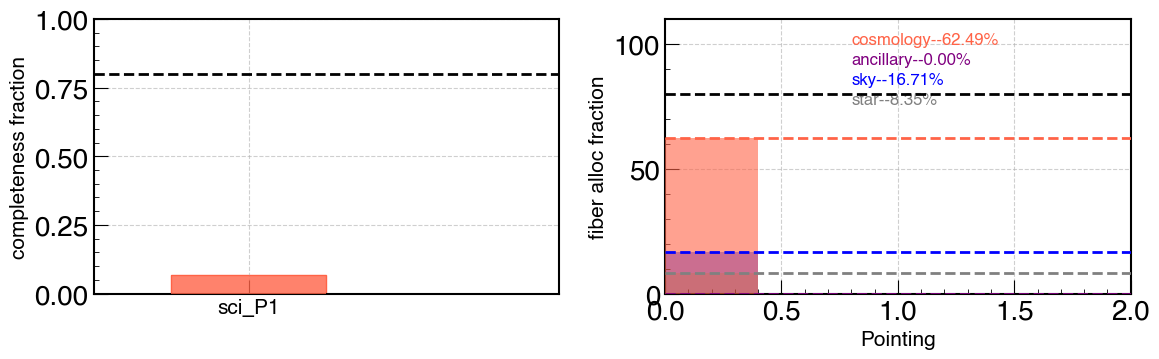

comp_out_tmp1 =  {'cal': 0.34305317324185247, 'sci_P1': 0.06721782890007189, 'sky': 0.008197897239358105}
493.169046 secs passed after the visits done.


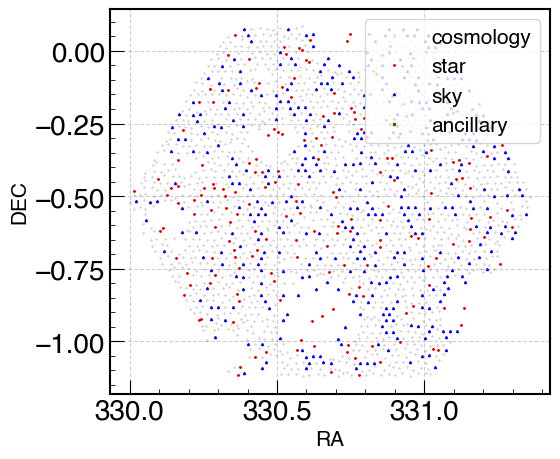

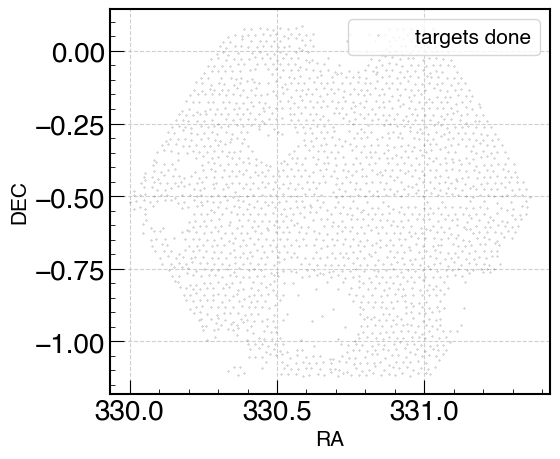

In [17]:
'''
Comment: can not get results without trajectory collision even if I run the code for more than 10 minutes
---------------------------------------------------------------------------
ERROR: detected end point collision, which should be impossible
trajectory collisions found: 4
'''
run_main(peaks, tgt, classdict, alreadyObserved, two_stage=two_stage, collision_sim_version=collision_sim_version, bench=bench, cobracoach=cobracoach, gurobiOptions=gurobiOptions, tele_params=tele_params)

In [18]:
#tclassdict = {'sci_P1' : 1, 'sky' : 2, 'cal' : 3}
#write_pfsDesign(outdir, 'pfsDesign_region3_3h_v1.txt', res, tpos, telescopes, tgt, classdict)

# TO-DO Lists
+ fix the problem of gurobi.lic in py_env_co_fa
+ update the target list after each observation
+ second visit, pointing center shift to avoid vignetting 
+ longer exposure option for second visit
+ (DONE!) remove the calibration targets in AlreadyObserved dict

+ (DONE!) CollisionSimulator versus SollisionSimulator2? 
+ cobra home position and collision simulator? 
+ generate 1h pfsDesign file using the code block above (CO will use first 6-8 hours)
+ (DONE!) (Q: iPS1 mag>18 is ok?) apply magnitude cut on bright stars
>>> Wanqiu: fainter than 16 (18 might be safer choice according to Andy)
+ (DONE) increase the sky/star fibers
>>> Masayuki - FLUXSTDs: 100-200 stars are good. Please distribute these stars uniformly across the field. 

+ fiberStatus? -- bad fibers and bad Cobra
+ apply bright star mask to sky/stars
+ generate uniform sky/star fiber assignment 
>>> Masato Onodera - I don't think I can put my script to check the uniformity of the distributions of sky and fluxstd objects against the home positions of science fibers. Please see the following gist how it's made. It uses dcor package for the comparsion, so making your own should be simple.
For the GA Fornax design, there is no configuration with p<0.05 (if my calculation is right).
https://gist.github.com/monodera/4c6fef2ce6a8370338250cd78ac78f26

>>> refer GA group code -
https://github.com/Subaru-PFS-GA/ga_targeting/blob/master/nb/examples/netflow/8_cobra_groups.ipynb



# check list for the observatory Target Uploader
+ CO netflow output targets all get a fiber assigned (test myself - use output as an input, all targets have the same cost)
+ two stage == different cost (same sky coverage)?
+ CO needs to track the status of the target list and instrument
+ if different otime is used, how many targets (sci, sky, star separately) will be missed? (test myself - use output as an input)

